In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

# Chapter 7 - ULYSSES’ COMPASS

## End of Chapter Problems

### 7E1.

State the three motivating criteria that define information entropy. Try to express each in your
own words.

#### Answer 
 There are the usual desidirata which are given such as continuity, additivity etc. I think these are hard to imagine coming up with these desidirata in the first place unless you had a wild and strong intuition for what properties "information" really ought to have. I actually think the best motivation for this definition comes from the conclusion of Shannon's Source Coding Theorem which is roughly as follows: If we have a sample $\underline{X}_N$ of i.i.d random variables $X_i$ from a distribution F. If H is the entropy of the distribution F, then as the sample size $N \to \infty$, the number of binary digits required per symbol, to encode the sample with negligible probability of error is the same as the entropy.

### 7E2.
Suppose a coin is weighted such that, when it is tossed and lands on a table, it comes up heads
70% of the time. What is the entropy of this coin?

#### Answer 
 $H(X) = -\sum_i P_i log(P_i)$

I'm using base 2 logarithm as it feels more natural (ironically) than the natural logarithm when it comes to information theory.
For the particular probability measure assigned to the coin in the question this becomes -0.7log(0.7) - 0.3log(0.3)

In [3]:
-0.7 * np.log2(0.7) - 0.3 * np.log2(0.3)

0.8812908992306927

Ie, less than one binary digit per coin flip is required when many coin flips are aggregated together.

### 7E3.
Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

In [4]:
-0.2 * np.log2(0.2) - 0.25 * np.log2(0.25) - 0.25 * np.log2(0.25) - 0.3 * np.log2(0.3)

1.9854752972273344

This isn't far from an equiprobable die, therefore it's unsurprising that 2 bits of information are required. That is 2 bits of information can encode 4 states.

### 7E4.
Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?

#### Answer 
 $3 \times -\frac{1}{3}log(\frac{1}{3}) = log(3)$

### 7M1.

Write down and compare the definitions of AIC and WAIC. Which of these criteria is most
general? Which assumptions are required to transform the more general criterion into a less general
one?


#### Answer

$\text{AIC} = −2lppd + 2p$, and $\text{WAIC} = −2(lppd - \sum_i var_{\theta}[ log p(y_i|\theta) ])$

WAIC is more general and is less constrained than the AIC. The AC works on flat priors and assumes multivariate Gaussian behaviour of the posterior, and sample size is much greater than the number of parameters.

### 7M2.

Explain the difference between model selection and model comparison. What information is lost under model selection?

#### Answer 
 Model selection picks a single model from a set based upon some criterion, eg out of sample prediction accuracy or out of sample deviance, and picks the model that optimises that metric.

Model comparison on the other hand retains all models and uses their relative performance metrics to assess the contributions of certain variables to making predictions. It can then be used in conjunction with a causal model, and its implied conditional independencies to judge some causal claims. But information criterion alone are not enought to do this.

### 7M3.

When comparing models with an information criterion, why must all models be fit to exactly the same observations? What would happen to the information criterion values, if the models were fit to different numbers of observations? Perform some experiments, if you are not sure.

#### Answer 
 Information criterion are calculated on in sample data. Changing the data would make this an unfair comparison.

Seeing as the information criterion are functions of -2𝑙𝑝𝑝𝑑, which is in turn an increasing function when more samples are added to the data. This is because lppd sums over all the data points. Using more observations for one model would mean there are more terms in the sum, thus using different size data sets would yield an unfair comparison of the two models.

### 7M4.

What happens to the effective number of parameters, as measured by PSIS or WAIC, as a prior
becomes more concentrated? Why? Perform some experiments, if you are not sure.


#### Answer 
 As the prior becomes narrower, the posterior becomes tighter for any given amount of data. Therefore, $\sum_i var_{\theta}[ log p(y_i|\theta) ]$ the variance on the penalty terms will become smaller. Why? Because as the posterior becomes narrower and narrower, the range of possible values of $log p(y_i|\theta)$ will become smaller and smaller.

### 7M5.

Provide an informal explanation of why informative priors reduce overfitting.

#### Answer 
 Informative prior concentrate mass on some specified region of the parameter space. In this regime you're implicity giving preference to some parameters and asking the model to require more data to shift probability mass in the posterior. The more mass you concentrate in the prior, the more data you need to shift it.

### 7M6.

Provide an informal explanation of why overly informative priors result in underfitting.

#### Answer 

Concentrating all of the probability mass into a small region means that a larger amount of data is required to move probability mass in the posterior. Thus using informative/narrow priors make the model unable to learn from smaller amounts of data.

### 7H1.

In 2007, The Wall Street Journal published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in (reconstructed
at right), seemingly by hand, to make the argument that the relationship
between tax rate and tax revenue increases and then declines, such that
higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in data(Laffer). Consider models
that use tax rate to predict tax revenue. Compare, using WAIC or PSIS, a
straight-line model to any curved models you like. What do you conclude
about the relationship between tax rate and tax revenue?

In [5]:
# Load the data
Laffer = pd.read_csv("./data/Laffer.csv", delimiter=";")

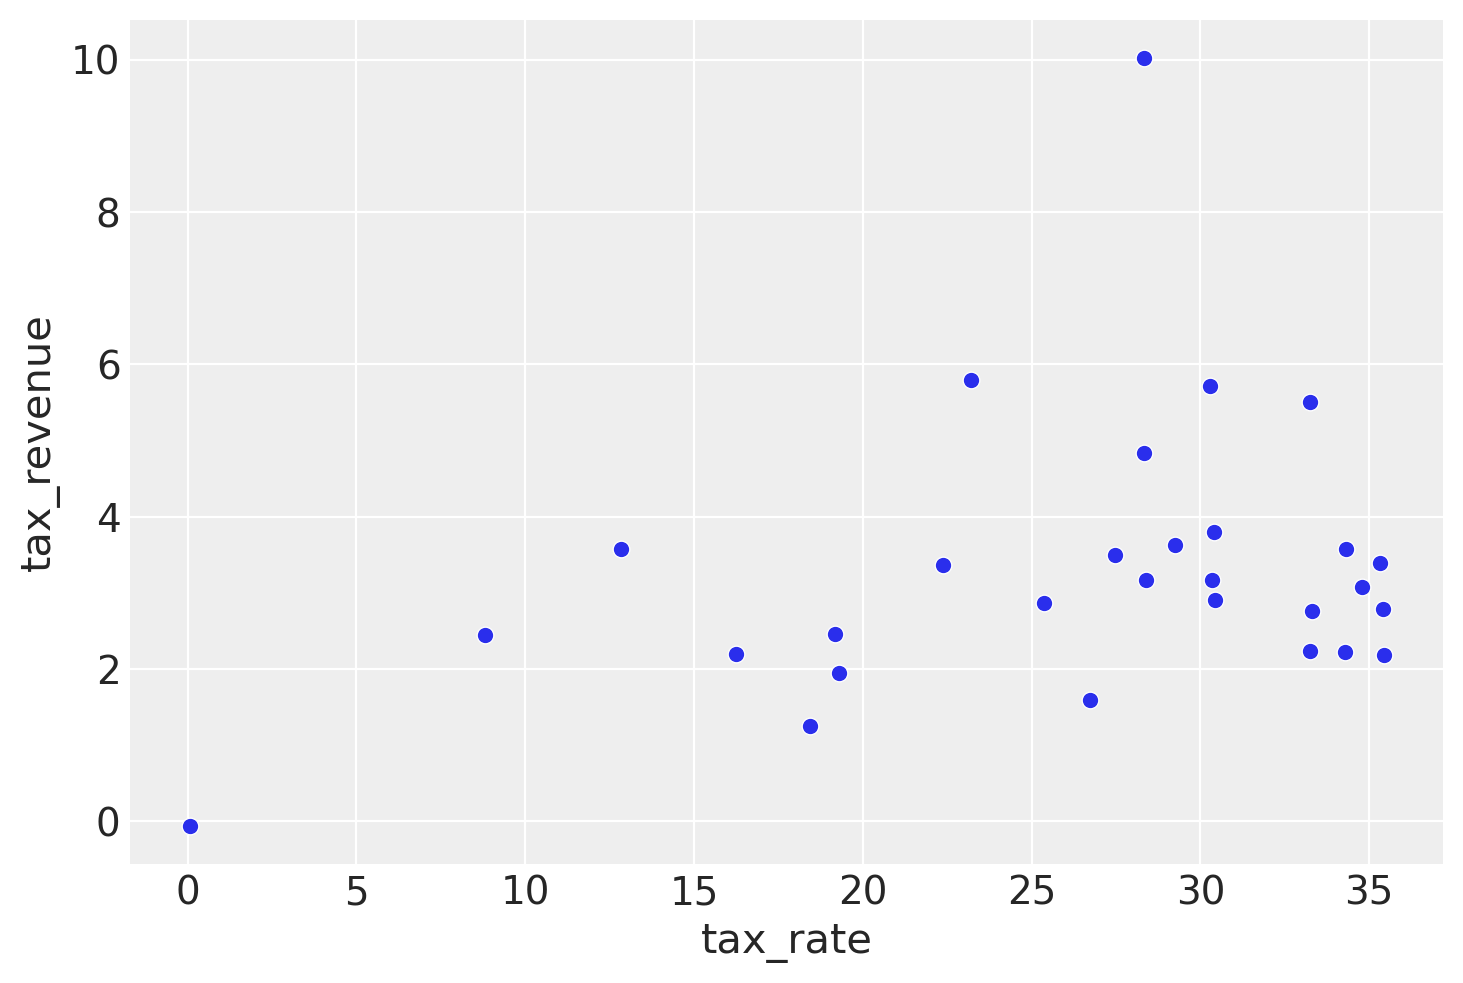

In [6]:
# plot it
sns.scatterplot(x="tax_rate", y="tax_revenue", data=Laffer);

Let's try 3 models for this data, each one a little a crazier than the last. I'll just fit polynomials from order 2, 3 and 5. This range of values ought to get the points across.

In [7]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

In [8]:
# standardise the data
Laffer["s_taxRate"] = standardise(Laffer.tax_rate)
Laffer["s_taxRevenue"] = standardise(Laffer.tax_revenue)

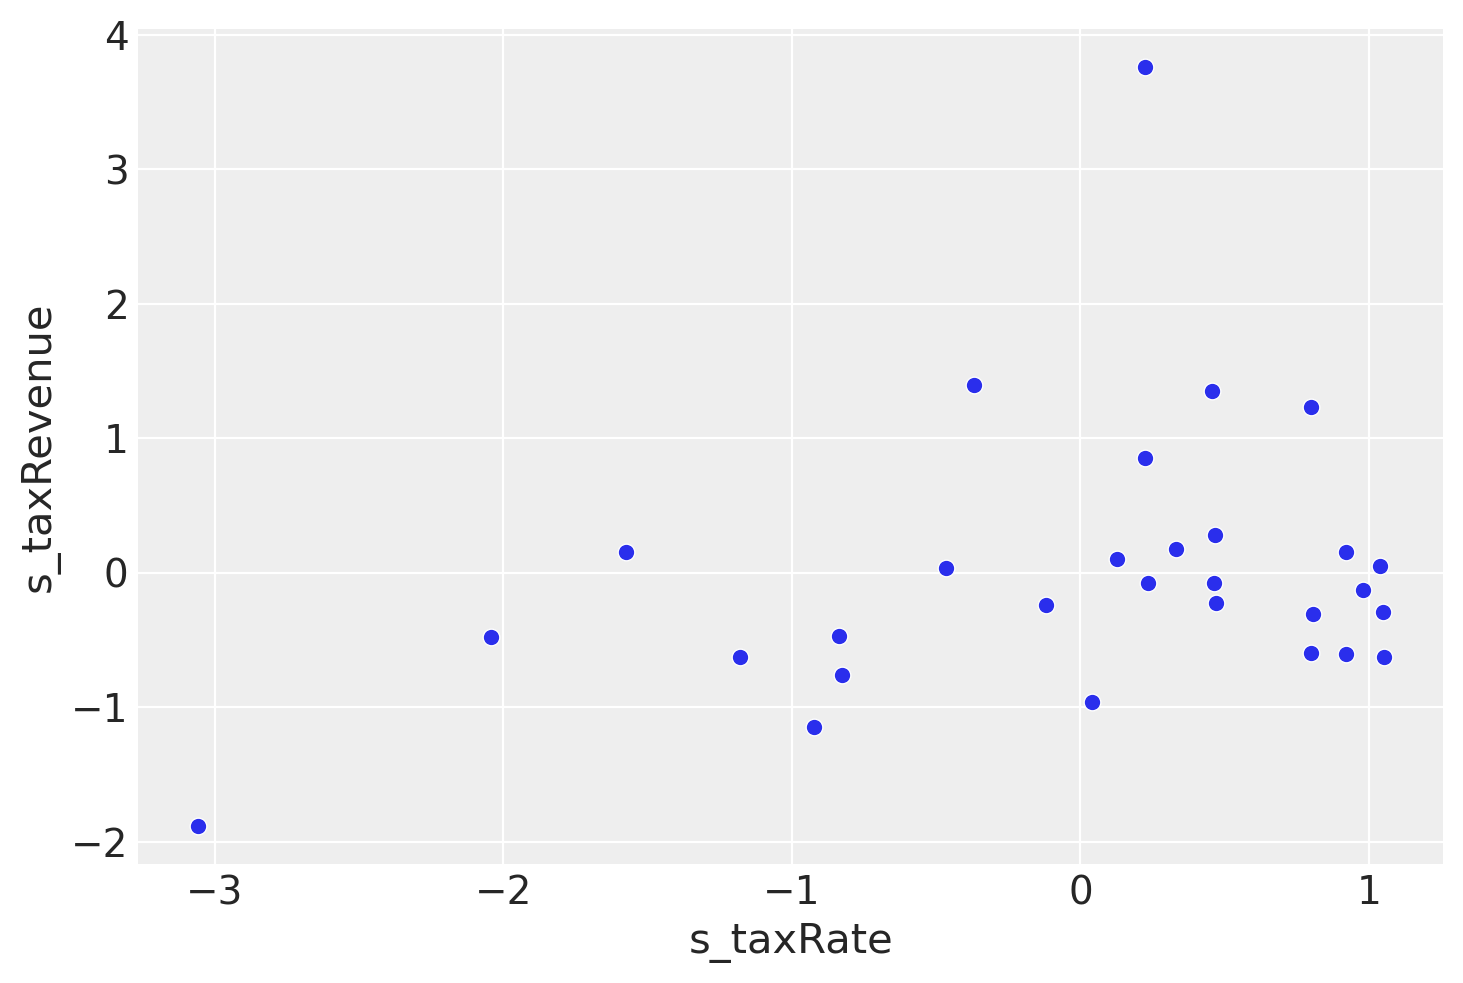

In [9]:
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer);

In [10]:
with pm.Model() as first:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 0.5, shape=1)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b * x)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    first_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)


with pm.Model() as second:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 0.5, shape=2)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    second_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

with pm.Model() as third:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 0.5, shape=3)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2 + b[2] * x ** 3)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    third_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

with pm.Model() as fourth:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 0.5, shape=4)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2 + b[2] * x ** 3 + b[3] * x ** 4)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    fourth_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8811846696694223, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8805249207808172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


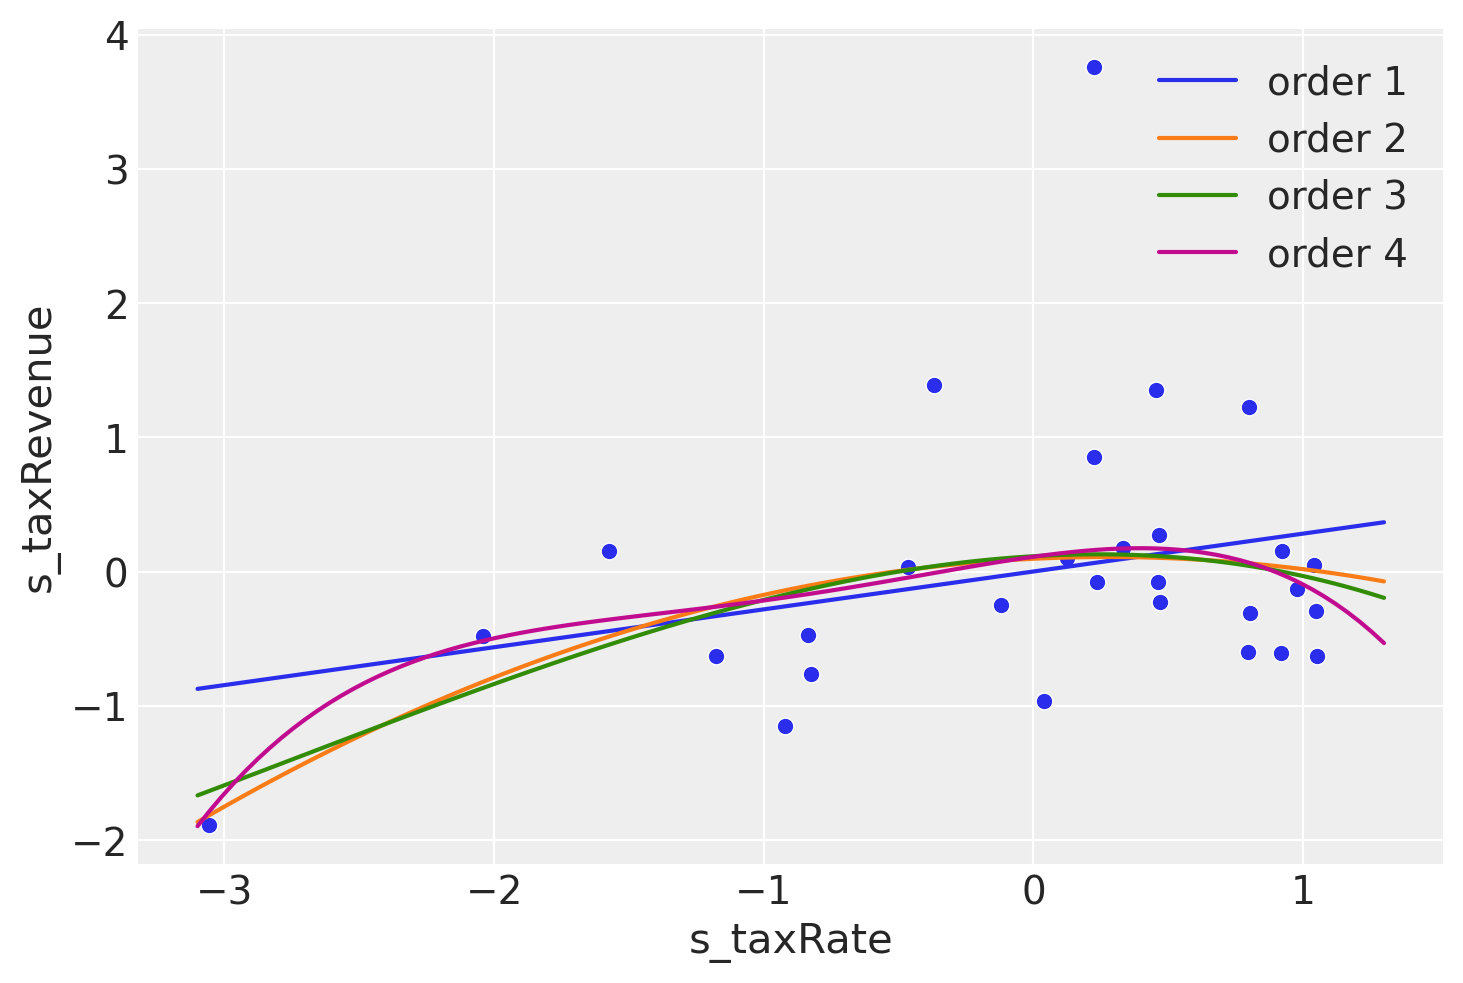

In [11]:
models = {1: first, 2: second, 3: third, 4: fourth}  # dictionary of the models
samples = [
    first_sample,
    second_sample,
    third_sample,
    fourth_sample,
]  # list the posterior samples
orders = [1, 2, 3, 4]

_, ax = plt.subplots()

for i, sample in zip(models.keys(), samples):  # iterate through models and samples
    with models[i]:  # set the model
        x = np.linspace(-3.1, 1.3, 100)
        pm.set_data({"x": x})
        ppc = pm.sample_posterior_predictive(sample, var_names=["mu"])
    ax.plot(x, ppc["mu"].mean(0), label="order " + str(i))
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer);

In [12]:
samples_dict = {1: first_sample, 2: second_sample, 3: third_sample, 4: fourth_sample}

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


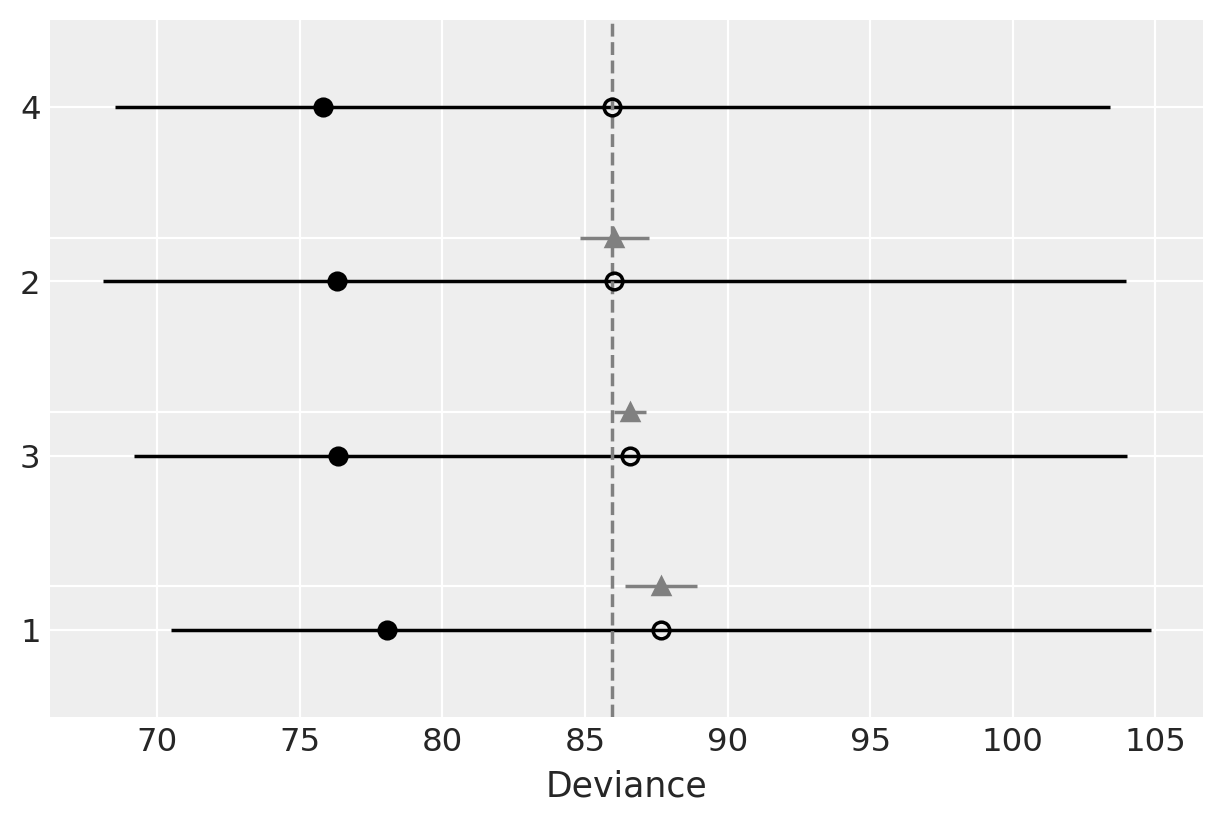

In [13]:
compare_df = az.compare(samples_dict, scale="deviance", ic="waic")
az.plot_compare(compare_df);

The models fit above were heavily regularized. Thus, the higher order 3rd and 4th order models don't add much more than the 2nd order model in terms of their fit to the data. This is reflected in the deviance. The 3rd order fit looks almost identical to the 2nd order model. The 3rd order model however has an additional parameter and offers very little in the way of extra predictive power. The 4th order model is noticeably different towards the left end of the figure, however this just fits a single data point better. In regions of the figure where the data is dense, it can be seen all the models are broadly in agreement. We can reduce the regularization below to see how this affects the models behaviour.

In [14]:
with pm.Model() as first:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 1, shape=1)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b * x)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    first_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)


with pm.Model() as second:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 1, shape=2)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    second_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

with pm.Model() as third:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 1, shape=3)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2 + b[2] * x ** 3)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    third_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

with pm.Model() as fourth:
    a = pm.Normal("a", 0, 0.2)  # alpha prior
    b = pm.Normal("b", 0, 1, shape=4)  # beta prior
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2 + b[2] * x ** 3 + b[3] * x ** 4)
    rev = pm.Normal("rev", mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    fourth_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8900123780292795, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


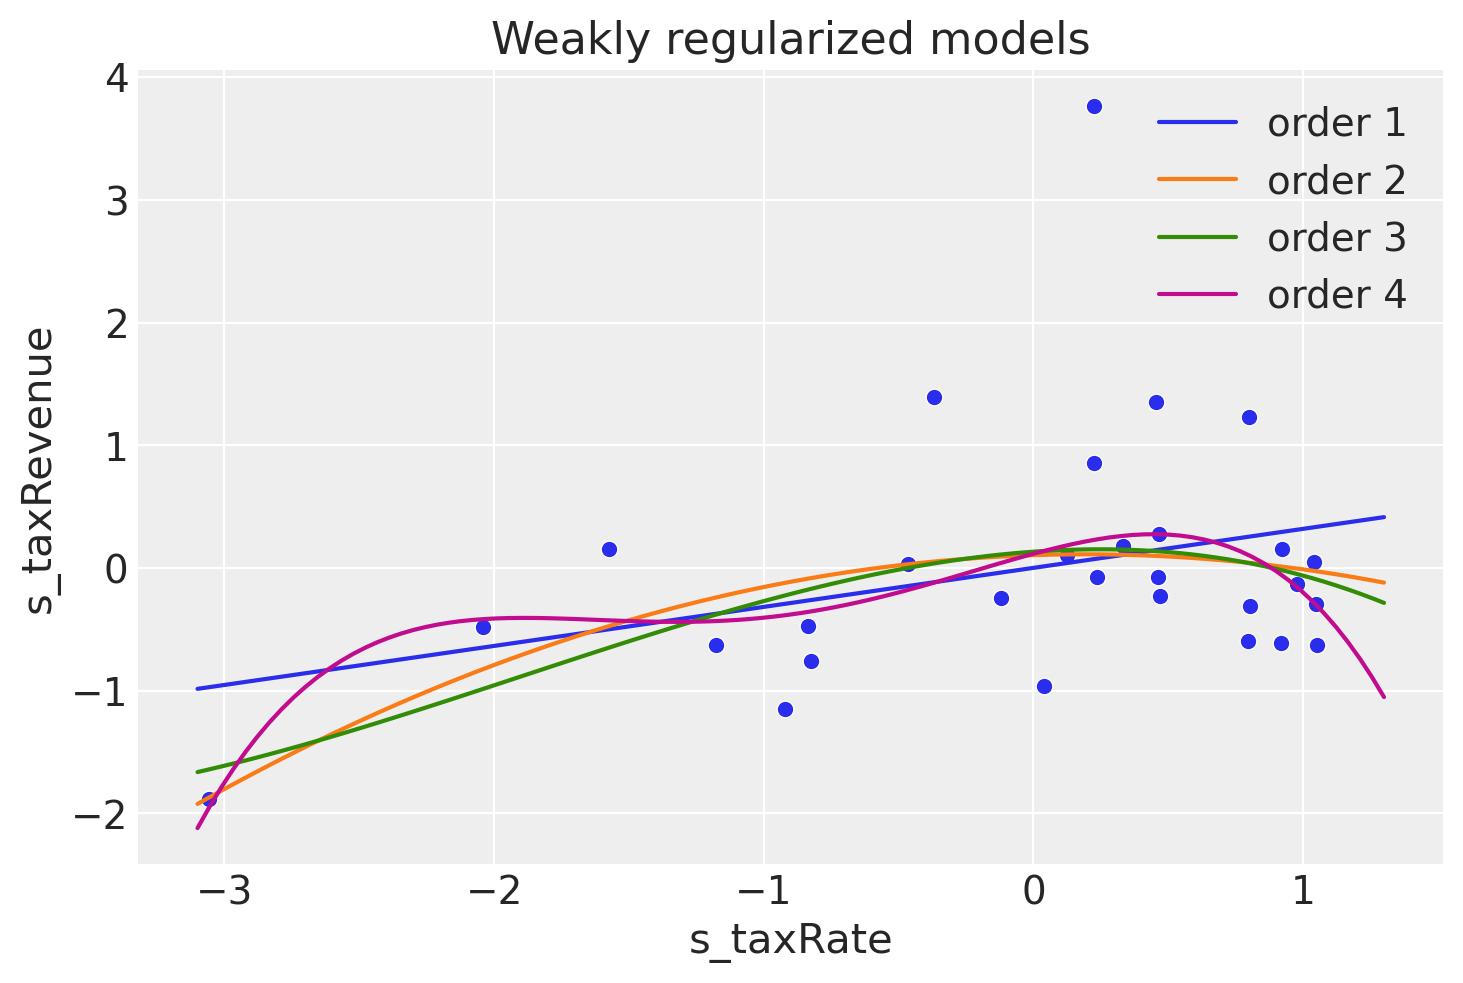

In [15]:
models = {1: first, 2: second, 3: third, 4: fourth}  # dictionary of the models
samples = [
    first_sample,
    second_sample,
    third_sample,
    fourth_sample,
]  # list the posterior samples
orders = [1, 2, 3, 4]

_, ax = plt.subplots()

for i, sample in zip(models.keys(), samples):  # iterate through models and samples
    with models[i]:  # set the model
        x = np.linspace(-3.1, 1.3, 100)
        pm.set_data({"x": x})
        ppc = pm.sample_posterior_predictive(sample, var_names=["mu"])
    ax.plot(x, ppc["mu"].mean(0), label="order " + str(i))
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer)
ax.set_title("Weakly regularized models");

In [16]:
samples_dict = {1: first_sample, 2: second_sample, 3: third_sample, 4: fourth_sample}

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


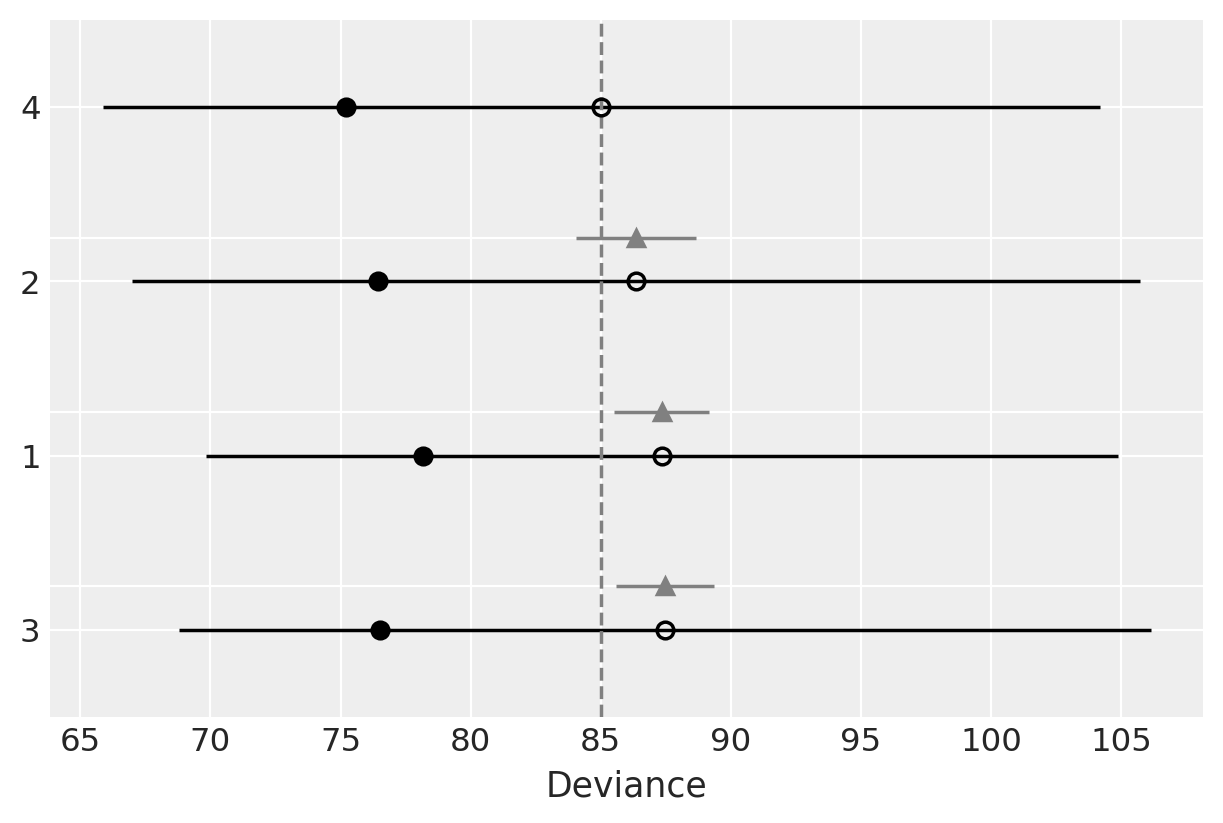

In [17]:
compare_df = az.compare(samples_dict, scale="deviance", ic="waic")
az.plot_compare(compare_df);

In [18]:
az.summary(second_sample, var_names=["b"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],0.079,0.240,-0.284,0.471,0.007,0.005,1039.0,1039.0,1044.0,1386.0,1.0
b[1],-0.185,0.128,-0.391,0.013,0.004,0.003,856.0,856.0,861.0,1174.0,1.0


If we reduce the regularization we can see greater overfit in the models, as out of sample performance declines. Regardless of the regularization, it should be noted that adding more non-linear effects beyond the second order polynomial ceases to substantial predictive power to the model as can be seen by inspecting the deviance in the models. Moreover, non of these models exhibit anything like the behaviour in the published article.

### 7H2.
In the Laffer data, there is one country with a high tax revenue that is an outlier. Use PSIS
and WAIC to measure the importance of this outlier in the models you fit in the previous problem.
Then use robust regression with a Student’s t distribution to revisit the curve fitting problem. How
much does a curved relationship depend upon the outlier point?

#### Answer
Let's do this for the 1st order linear relationship.

In [19]:
with first:  # set the model
    x = np.linspace(-3.1, 1.3, 100)
    pm.set_data({"x": x})
    ppc = pm.sample_posterior_predictive(first_sample, var_names=["mu"])

In [20]:
# compute the waic and psis
first_waic = pm.waic(first_sample, first, scale="deviance")
first_loo = pm.loo(first_sample, first, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


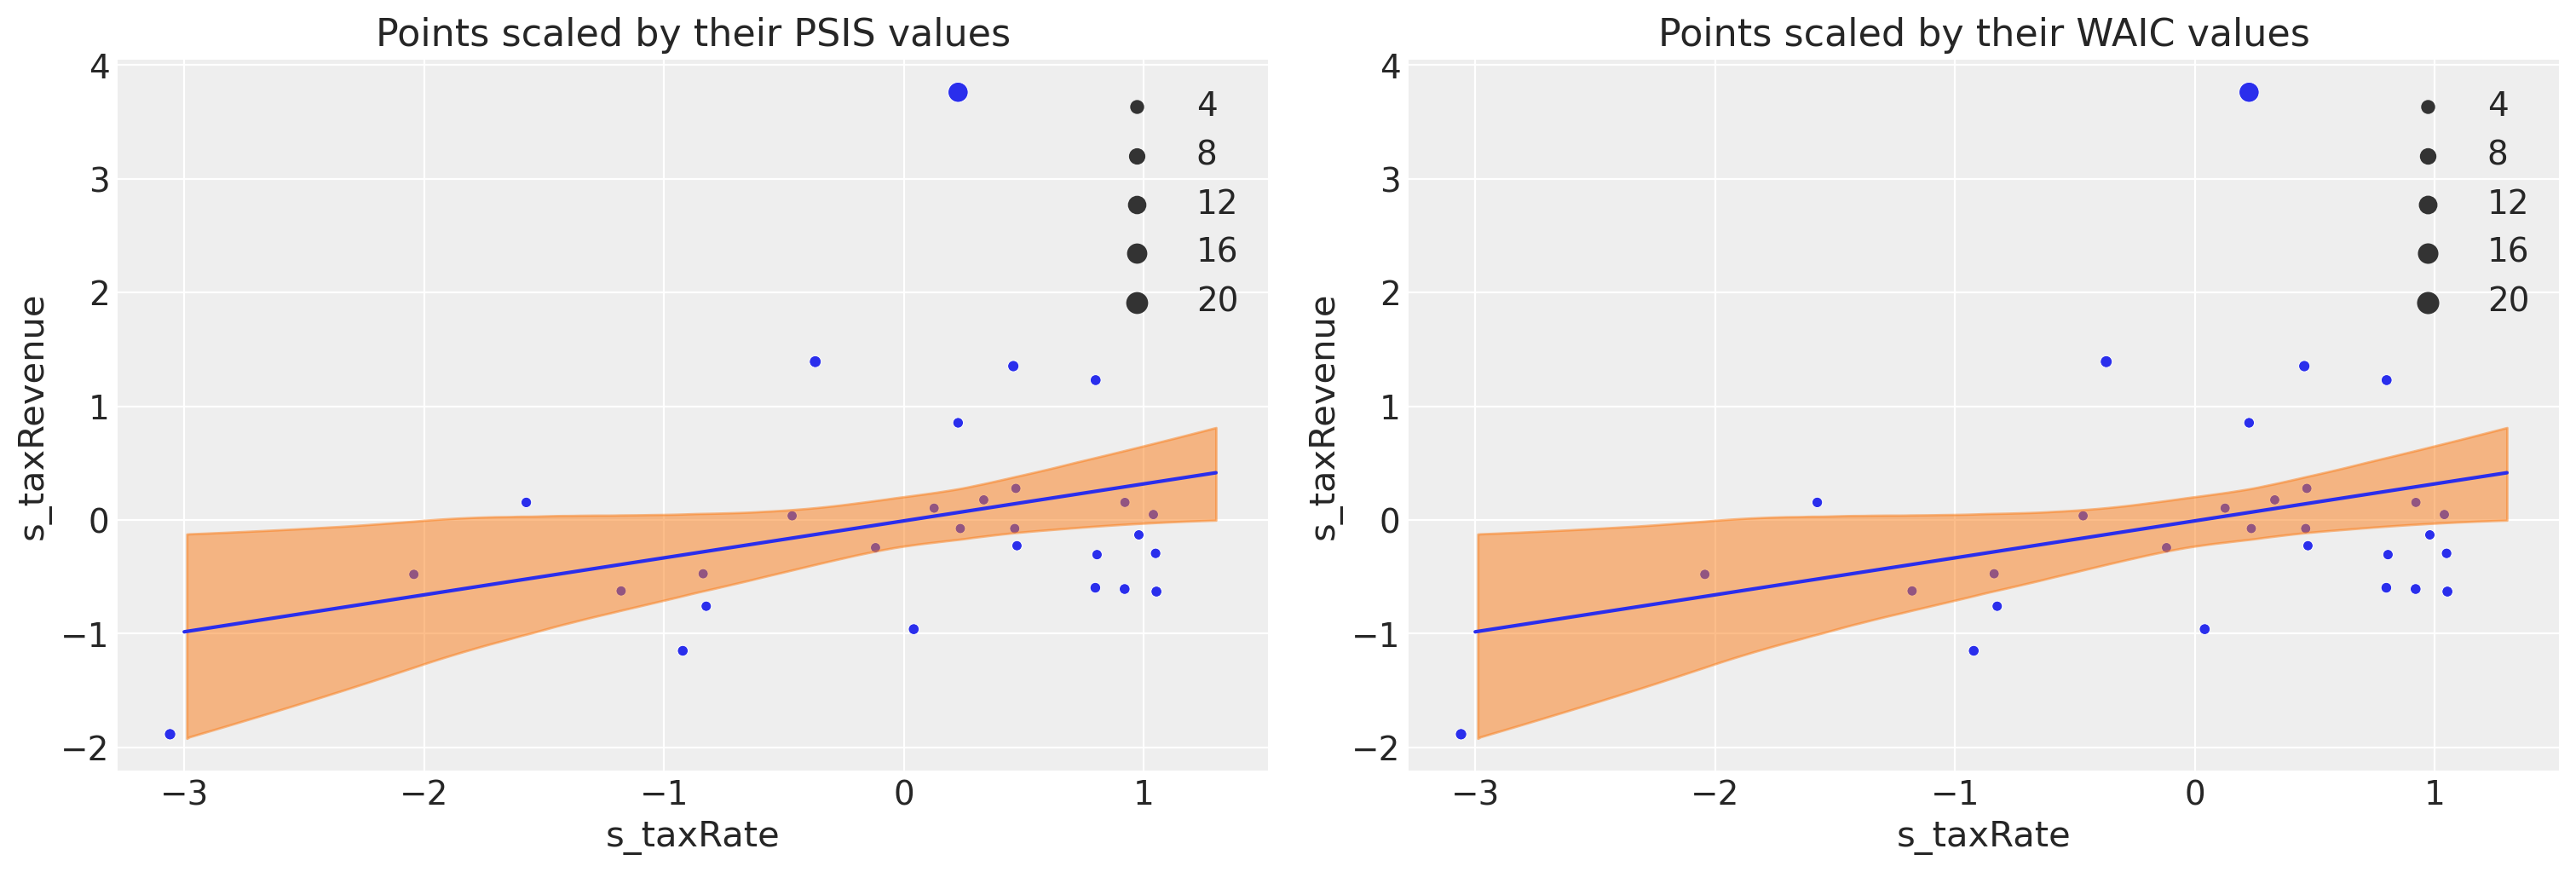

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.3, 100)
y = ppc["mu"]

axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(
    x="s_taxRate", y="s_taxRevenue", data=Laffer, size=first_loo.loo_i.values, ax=axs[0]
)
axs[0].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[0])

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=first_waic.waic_i.values,
    ax=axs[1],
)
axs[1].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[1]);

Now we'll train a robust linear regression using a student-t error model for the data, instead of the usual Gaussian jazz.

In [22]:
with pm.Model() as robust_first:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5, shape=1)
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b * x)
    rev = pm.StudentT("rev", 2, mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    robust_first_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


In [23]:
with robust_first:  # set the model
    x = np.linspace(-3.1, 1.3, 100)
    pm.set_data({"x": x})
    robust_ppc = pm.sample_posterior_predictive(robust_first_sample, var_names=["mu"])

In [24]:
robust_first_loo = pm.loo(robust_first_sample, robust_first, scale="deviance")
robust_first_waic = pm.waic(robust_first_sample, robust_first, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


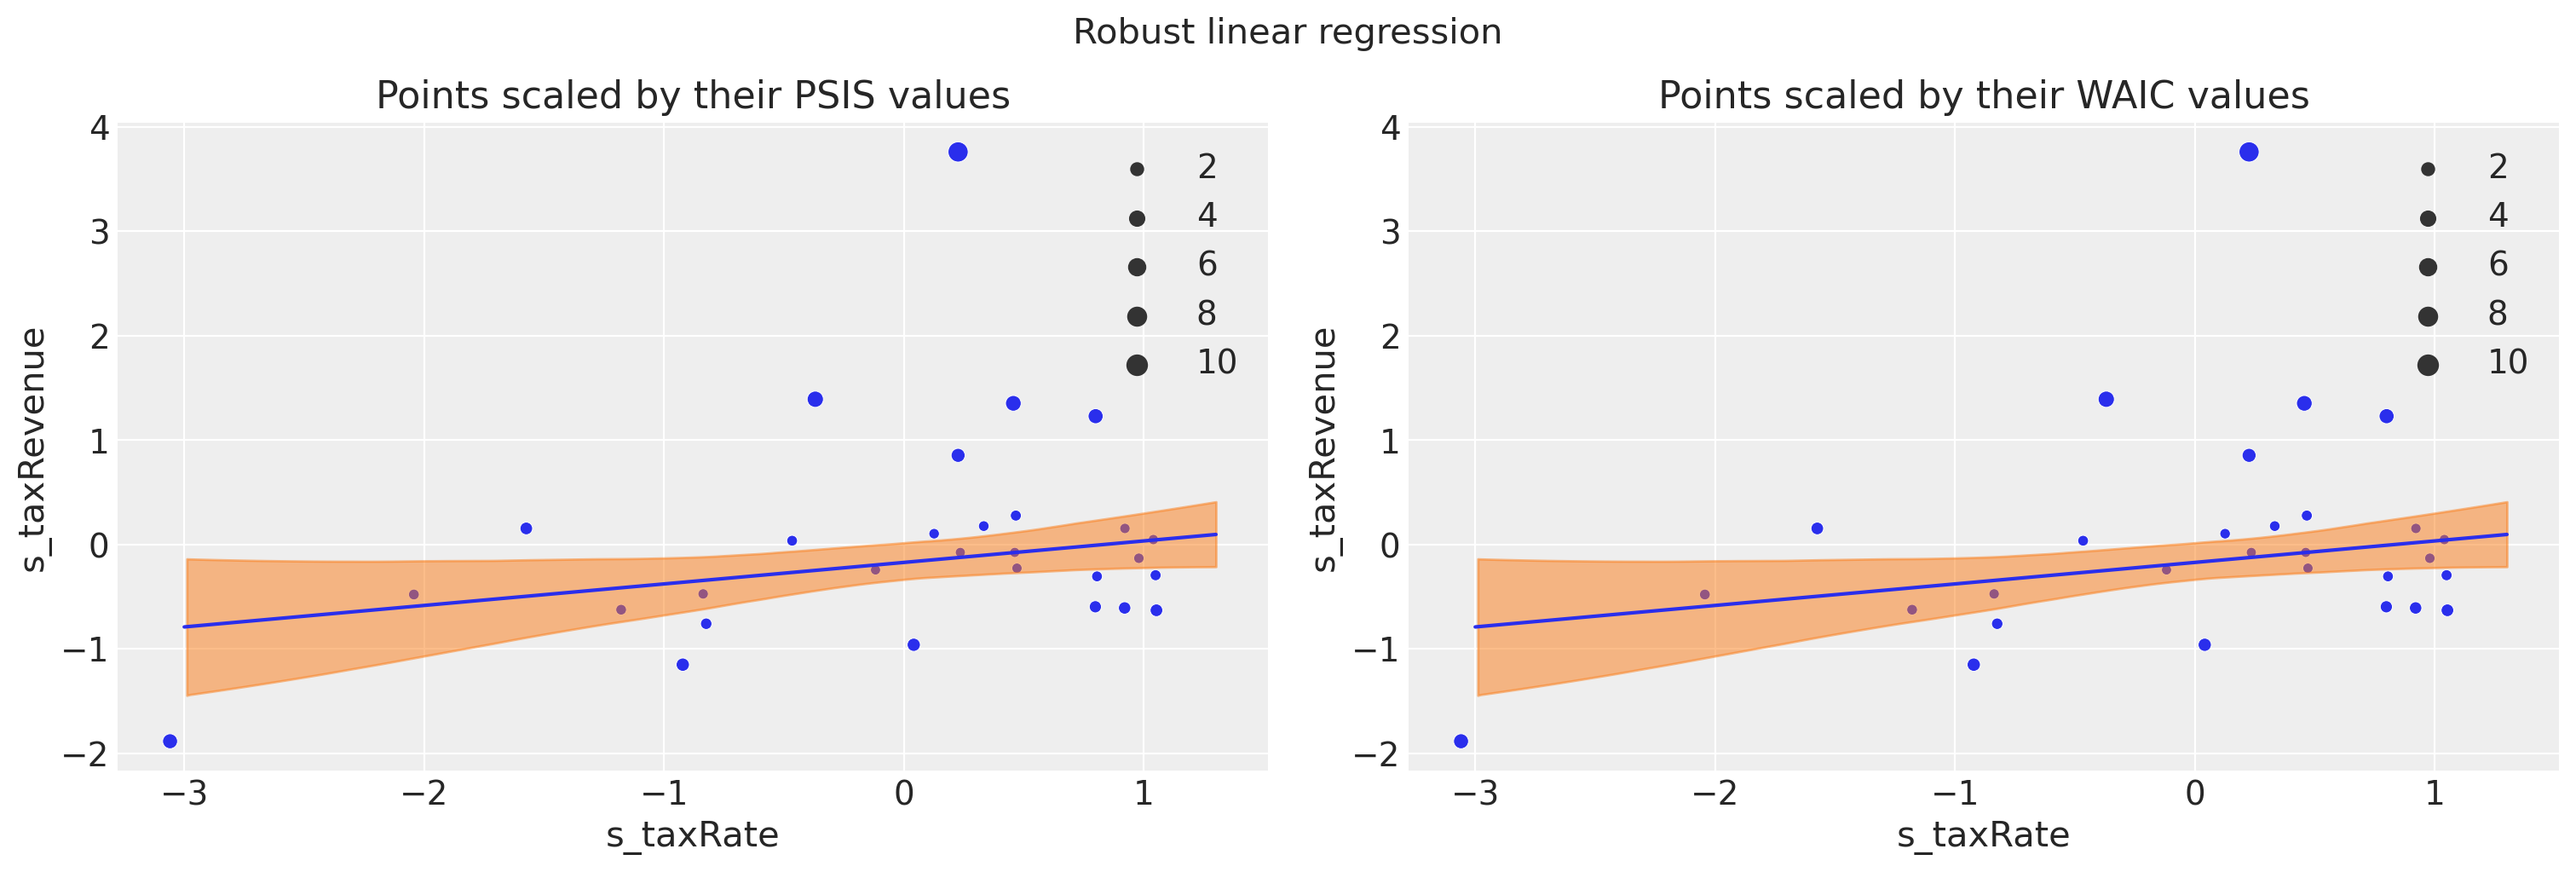

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.3, 100)
y = robust_ppc["mu"]

plt.suptitle("Robust linear regression", size=15)

axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=robust_first_loo.loo_i.values,
    ax=axs[0],
)
axs[0].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[0])

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=robust_first_waic.waic_i.values,
    ax=axs[1],
)
axs[1].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[1]);

As can be seen, the difference in size between the outlier values and the more expected values is less stark for the robust linear regression. That is the scale of WAIC & PSIS values goes from 2-10 for rubyst regression vs 2-20 for the conventional regression. Intuitively one might think of this as being something like the robust linear regression are more prepared for/expect the outlier events to occur, which is captured in the model by using the student-t as the likelihood.

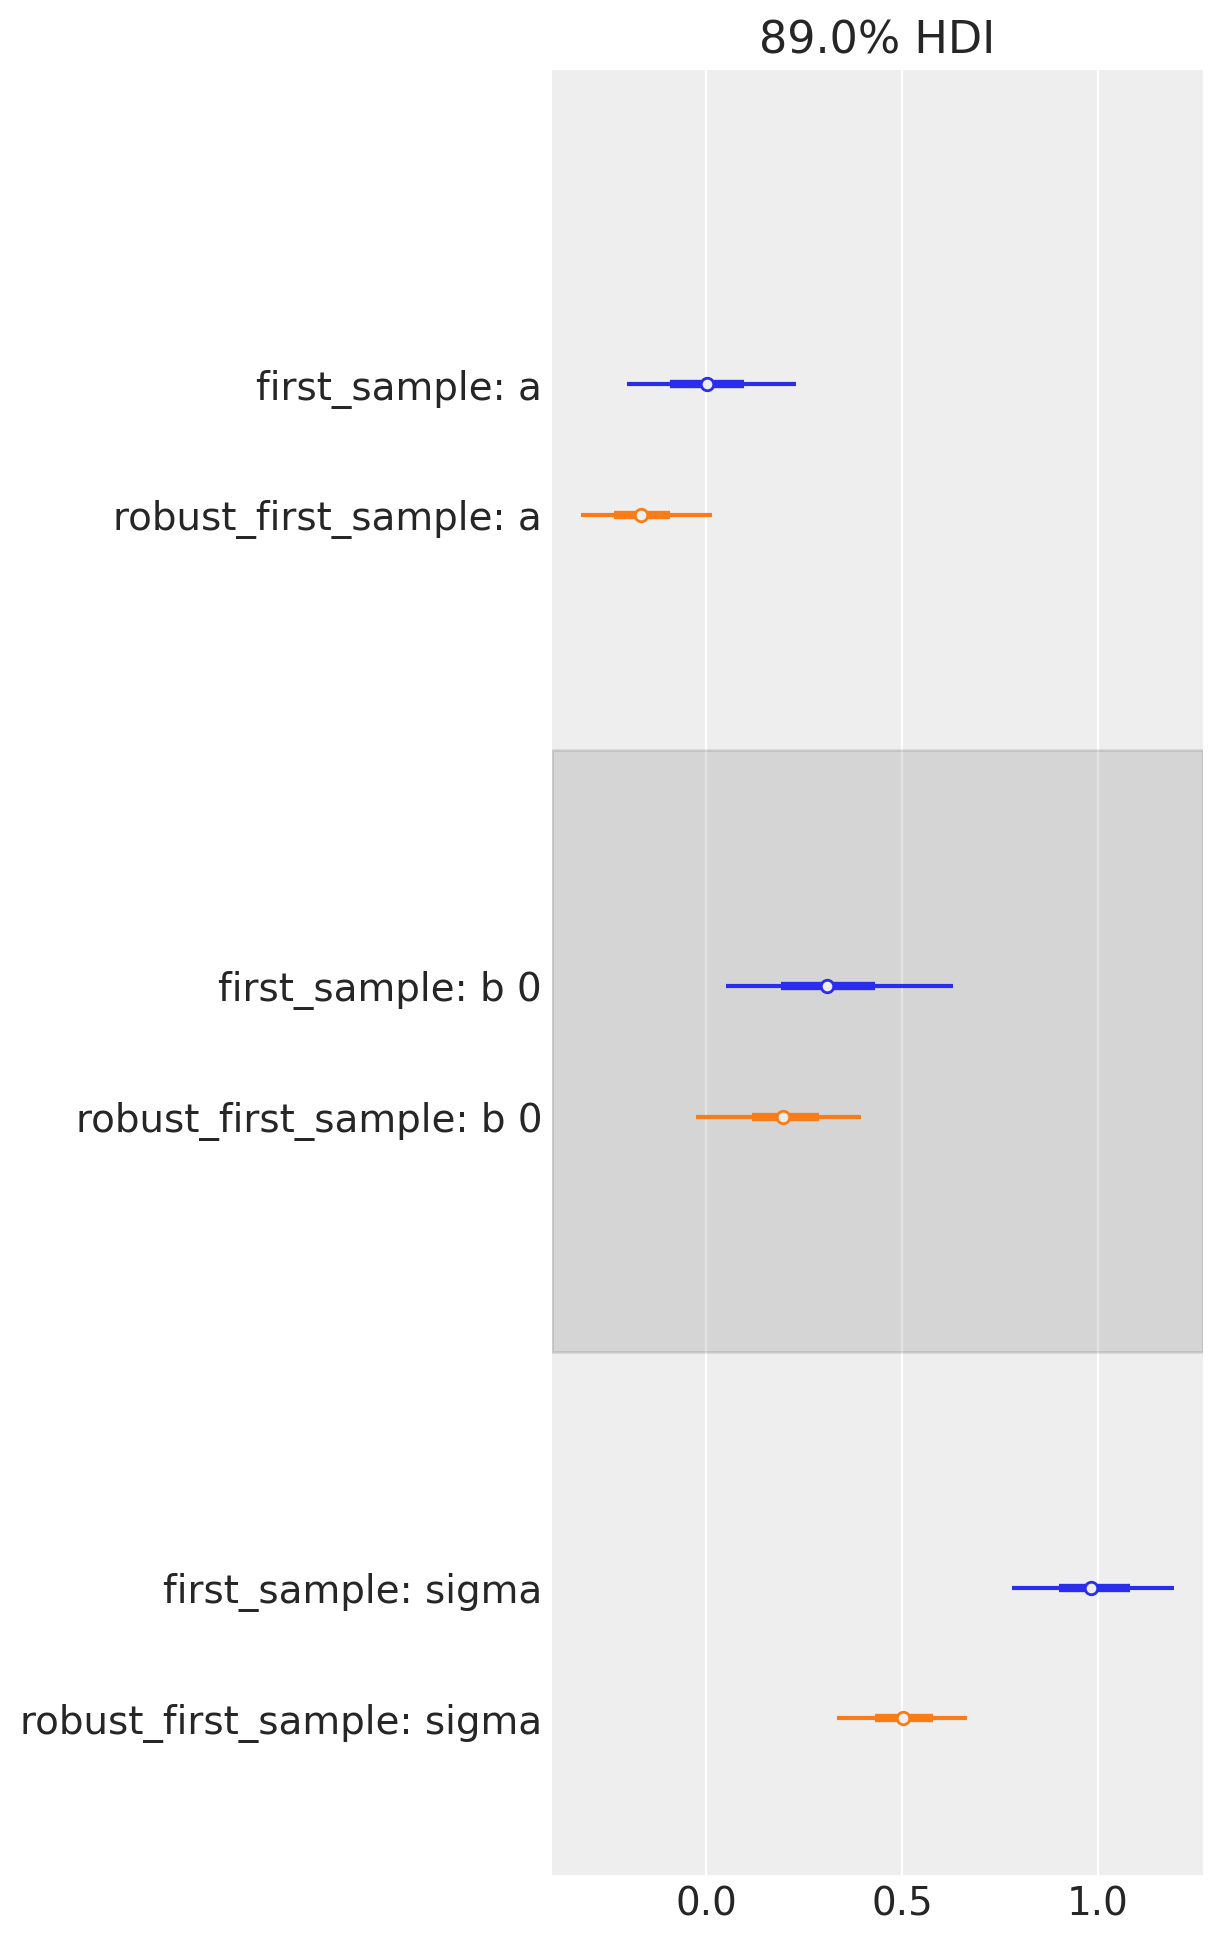

In [26]:
az.plot_forest(
    [first_sample, robust_first_sample],
    model_names=["first_sample", "robust_first_sample"],
    combined=True,
    var_names=["a", "b", "sigma"],
);

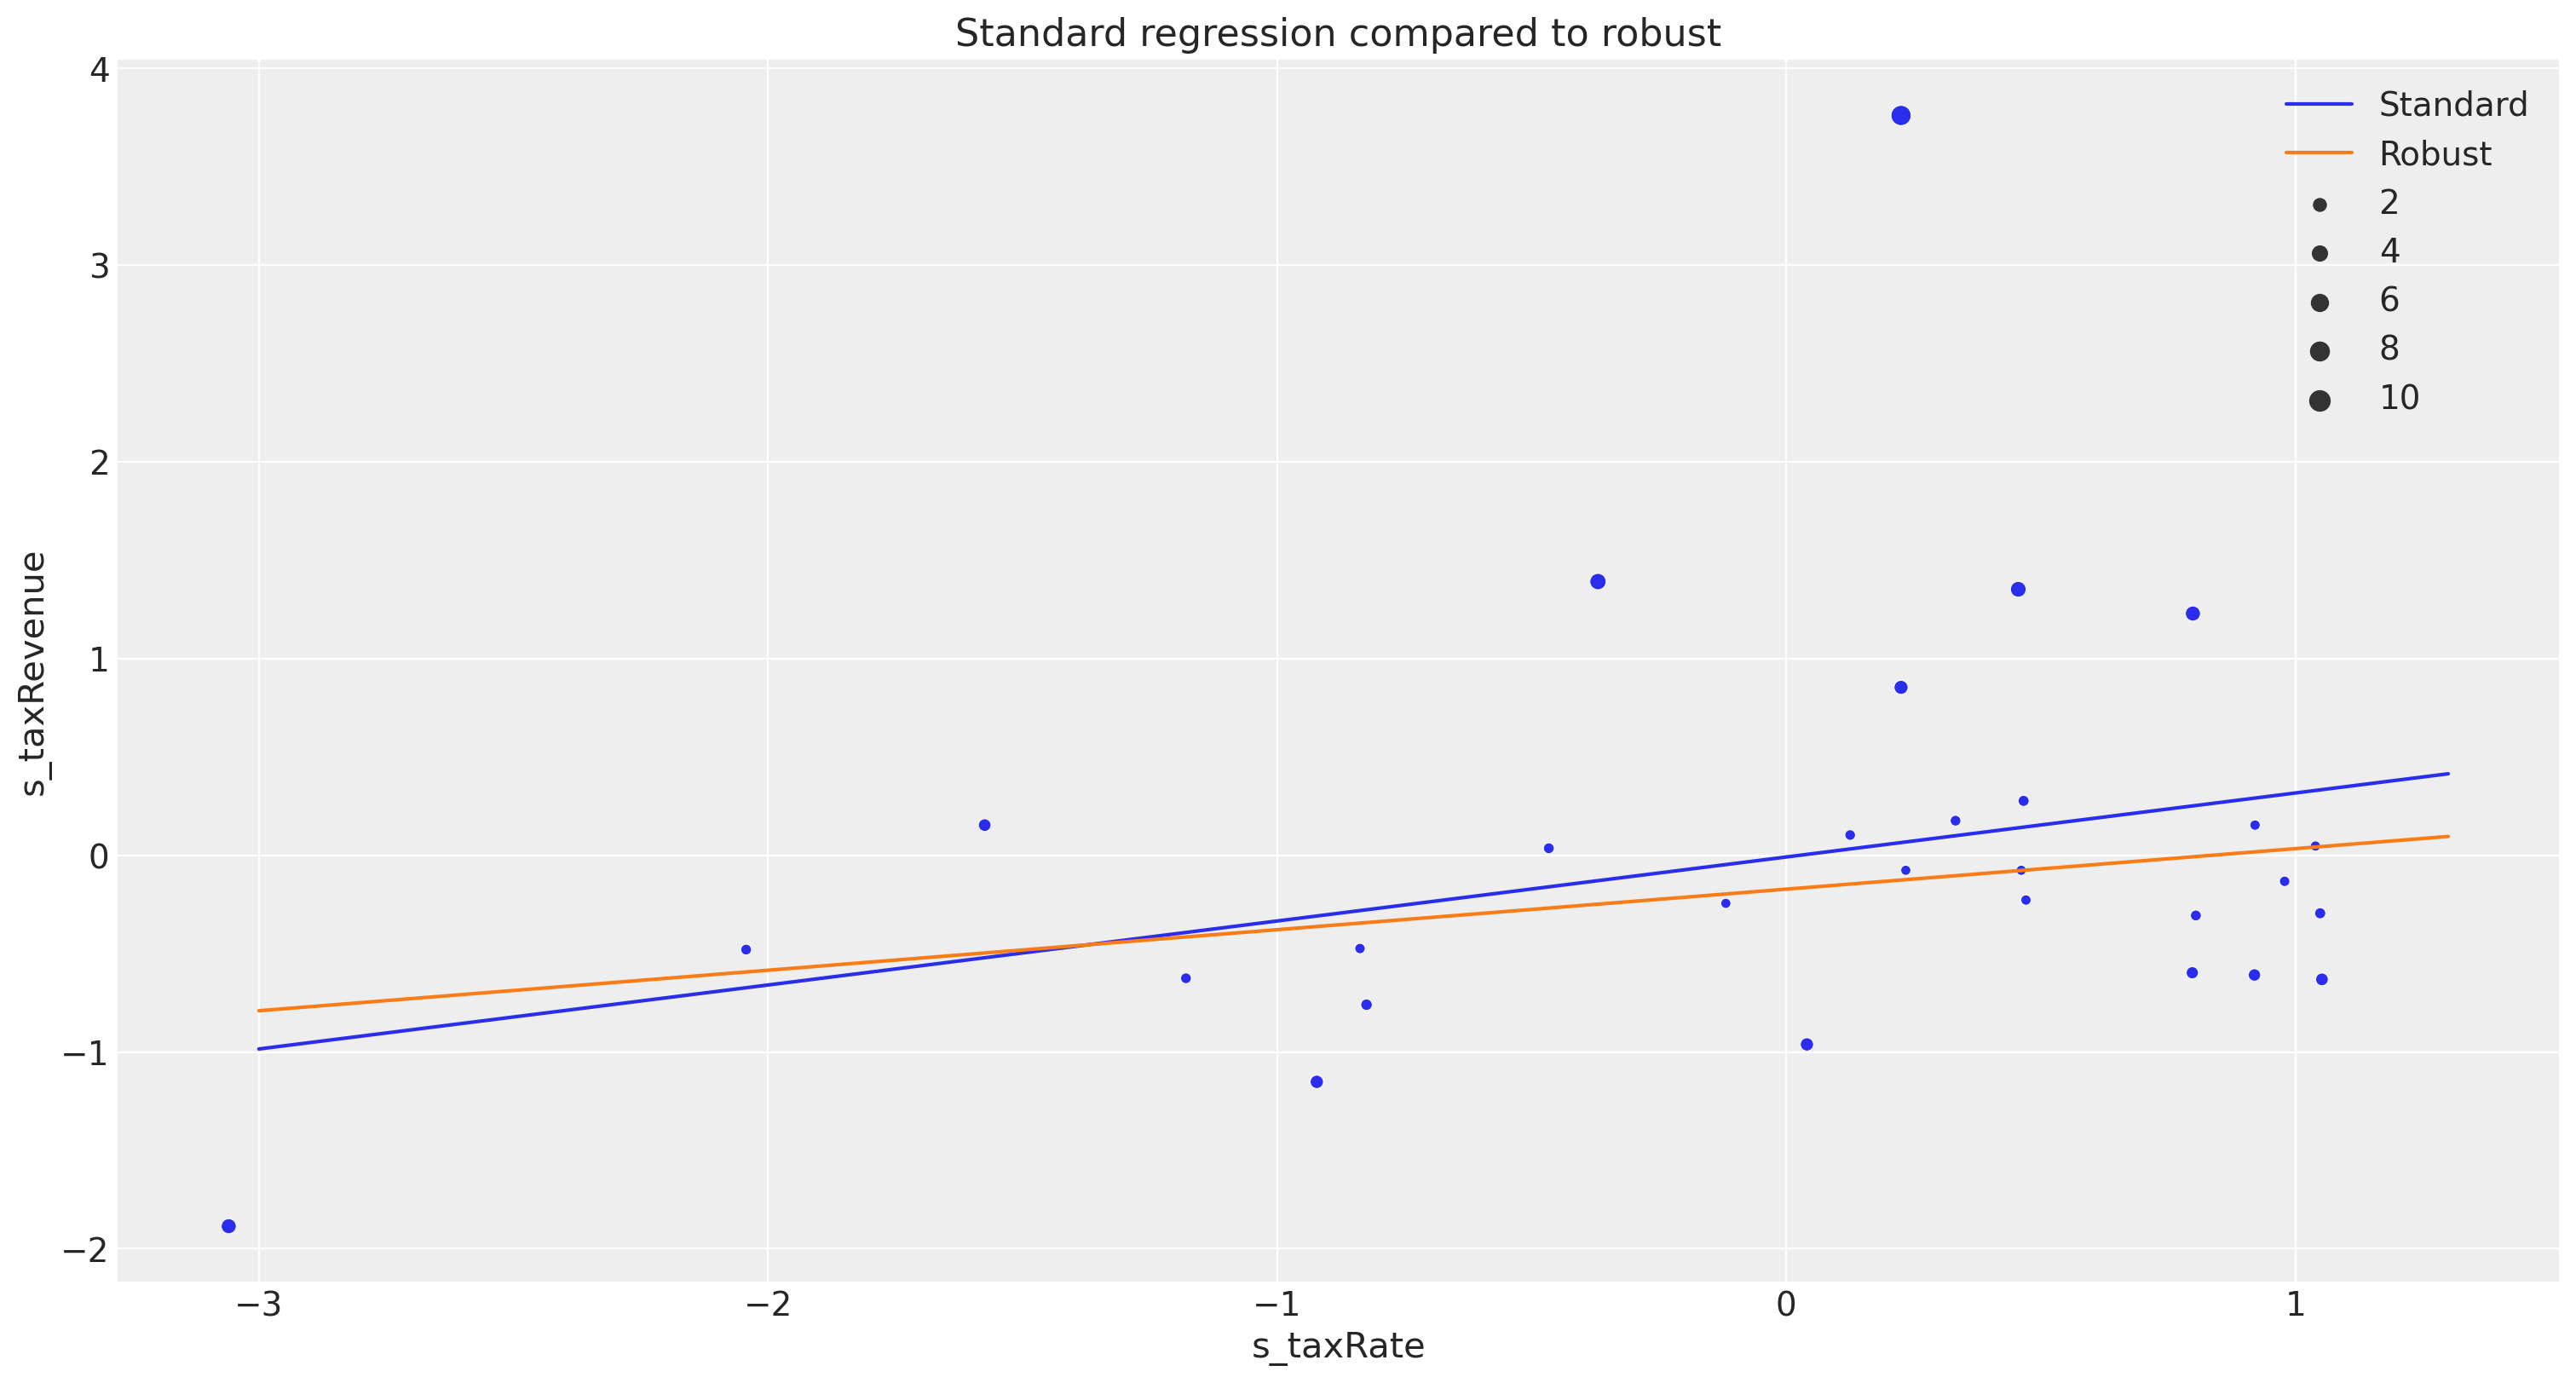

In [27]:
fig, axs = plt.subplots(figsize=(15, 8))

x = np.linspace(-3, 1.3, 100)
y1 = ppc["mu"]
y2 = robust_ppc["mu"]
plt.title("Standard regression compared to robust")
plt.plot(x, y1.mean(0), label="Standard")
plt.plot(x, y2.mean(0), label="Robust")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer, size=robust_first_waic.waic_i.values);

The linear model exhibits some modest changes as the the extreme high end outliers contribute far less to the expected effect size in the robust model. We now re-run the whole analysis for the second order model.

#### Answer
Let's do this for the 1st order linear relationship.

In [28]:
with second:  # set the model
    x = np.linspace(-3.1, 1.3, 100)
    pm.set_data({"x": x})
    ppc = pm.sample_posterior_predictive(second_sample, var_names=["mu"])

In [29]:
# compute the waic and psis
second_waic = pm.waic(second_sample, first, scale="deviance")
second_loo = pm.loo(second_sample, first, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:682: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


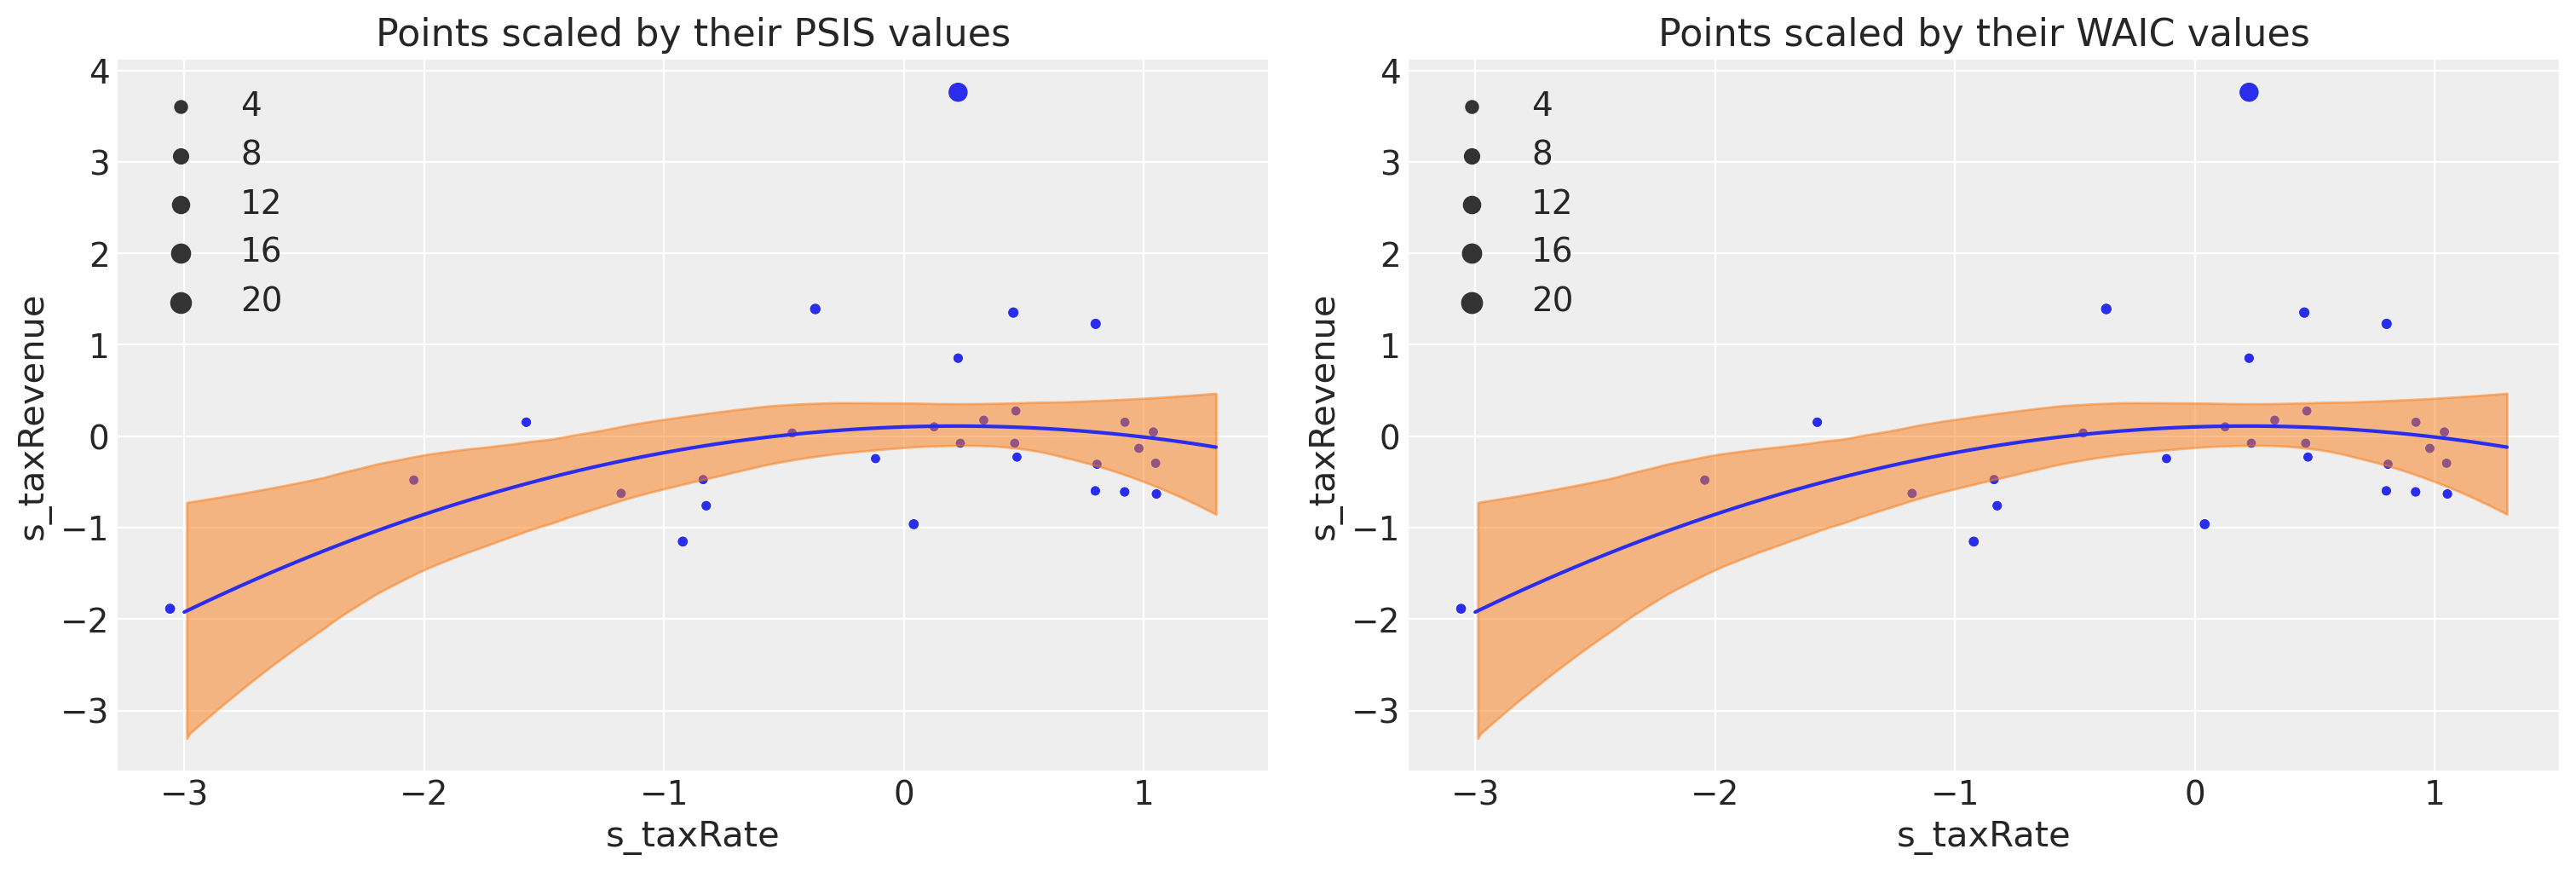

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.3, 100)
y = ppc["mu"]

axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=second_loo.loo_i.values,
    ax=axs[0],
)
axs[0].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[0])

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=second_waic.waic_i.values,
    ax=axs[1],
)
axs[1].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[1]);

Now we'll train a robust linear regression using a student-t error model for the data, instead of the usual Gaussian jazz.

In [31]:
with pm.Model() as robust_second:
    a = pm.Normal("a", 0, 0.2)
    b = pm.Normal("b", 0, 0.5, shape=2)
    sigma = pm.Lognormal("sigma", 0, 1)
    x = pm.Data("x", Laffer.s_taxRate)
    mu = pm.Deterministic("mu", a + b[0] * x + b[1] * x ** 2)
    rev = pm.StudentT("rev", 2, mu=mu, sd=sigma, observed=Laffer.s_taxRevenue)
    robust_second_sample = pm.sample(draws=500, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [32]:
with robust_second:  # set the model
    x = np.linspace(-3.1, 1.3, 100)
    pm.set_data({"x": x})
    robust_ppc = pm.sample_posterior_predictive(robust_second_sample, var_names=["mu"])

In [33]:
robust_second_loo = pm.loo(robust_first_sample, robust_first, scale="deviance")
robust_second_waic = pm.waic(robust_first_sample, robust_first, scale="deviance")

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


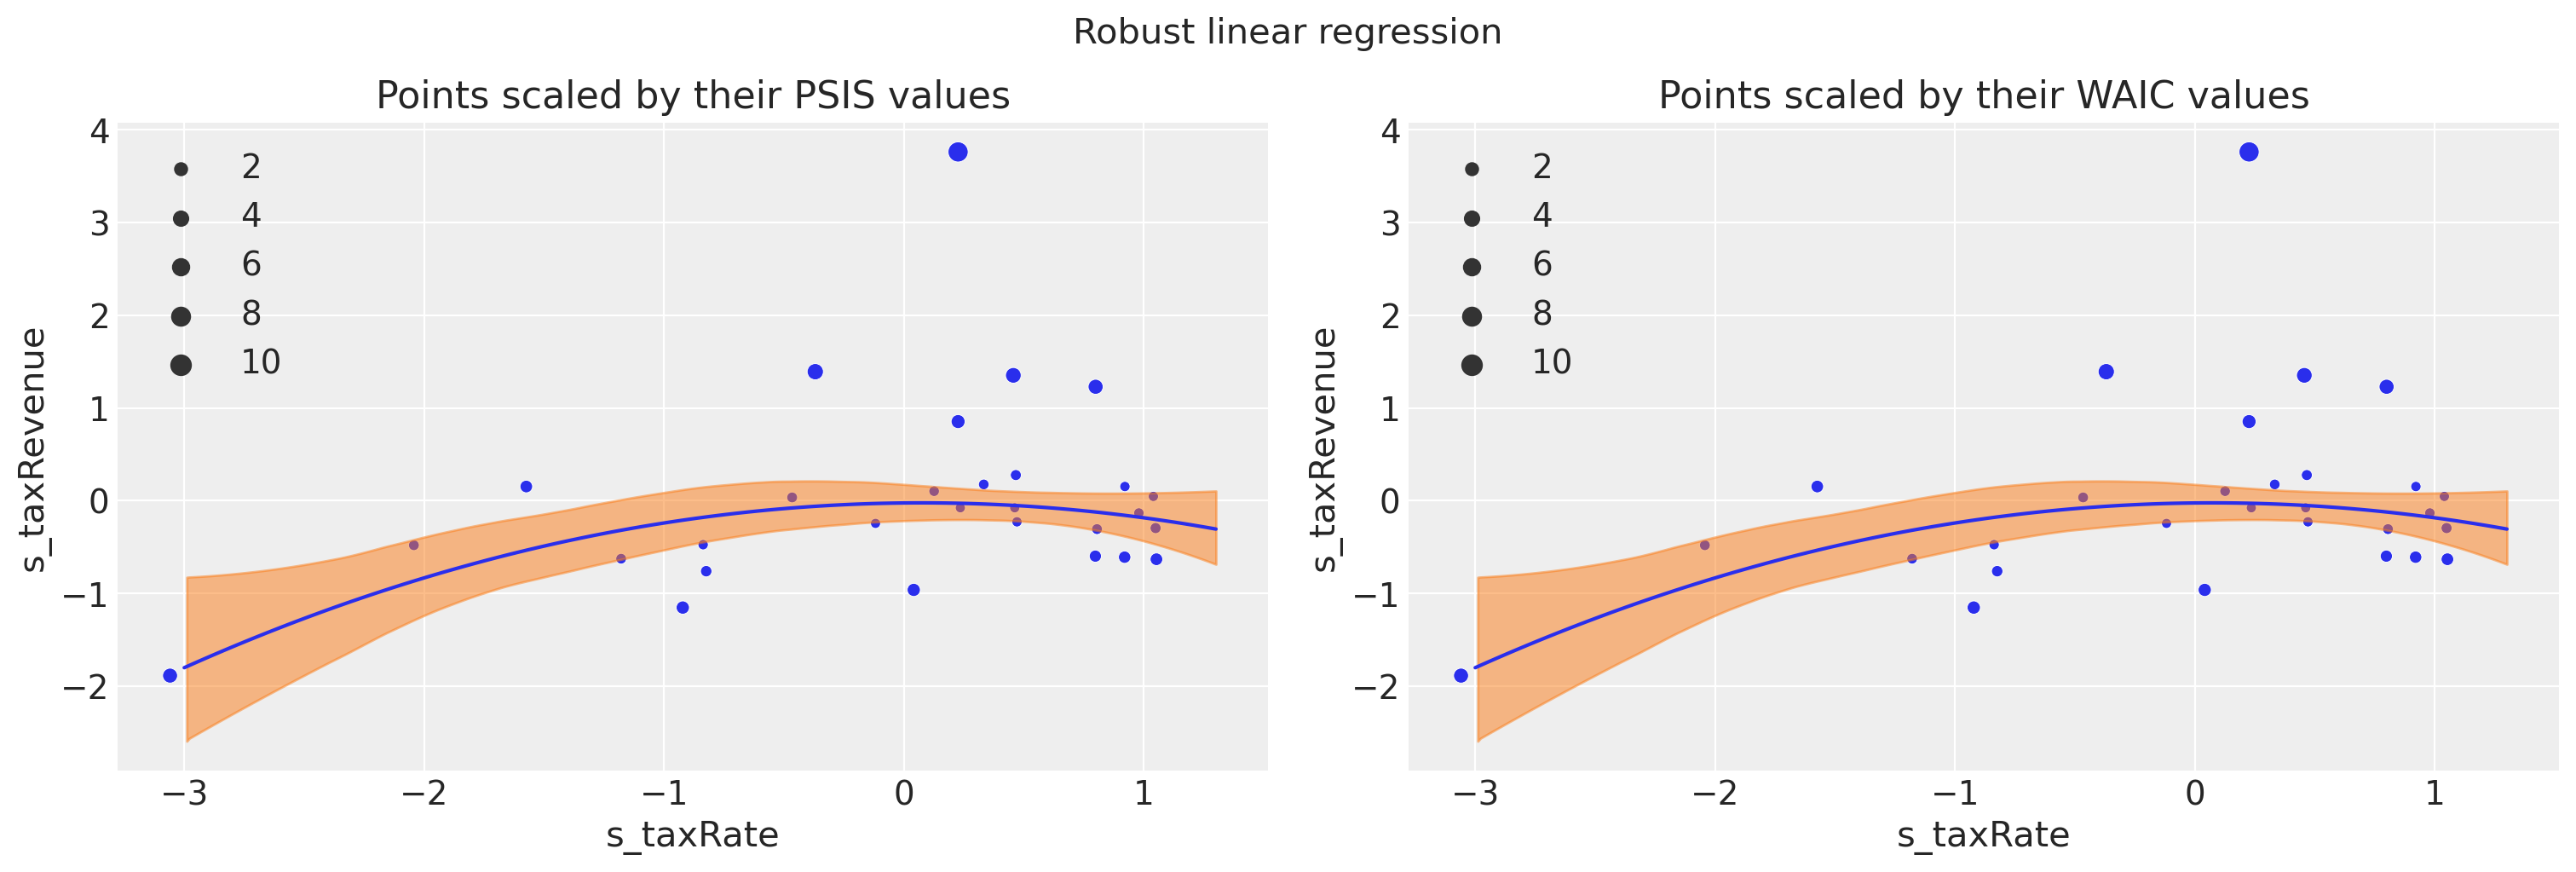

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(-3, 1.3, 100)
y = robust_ppc["mu"]

plt.suptitle("Robust linear regression", size=15)

axs[0].set_title("Points scaled by their PSIS values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=robust_first_loo.loo_i.values,
    ax=axs[0],
)
axs[0].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[0])

axs[1].set_title("Points scaled by their WAIC values")
sns.scatterplot(
    x="s_taxRate",
    y="s_taxRevenue",
    data=Laffer,
    size=robust_first_waic.waic_i.values,
    ax=axs[1],
)
axs[1].plot(x, y.mean(0))
az.plot_hdi(x, y, ax=axs[1]);

As can be seen, the difference in size between the outlier values and the more expected values is less stark for the robust linear regression. That is the scale of WAIC & PSIS values goes from 2-10 for rubyst regression vs 2-20 for the conventional regression. Intuitively one might think of this as being something like the robust linear regression are more prepared for/expect the outlier events to occur, which is captured in the model by using the student-t as the likelihood.

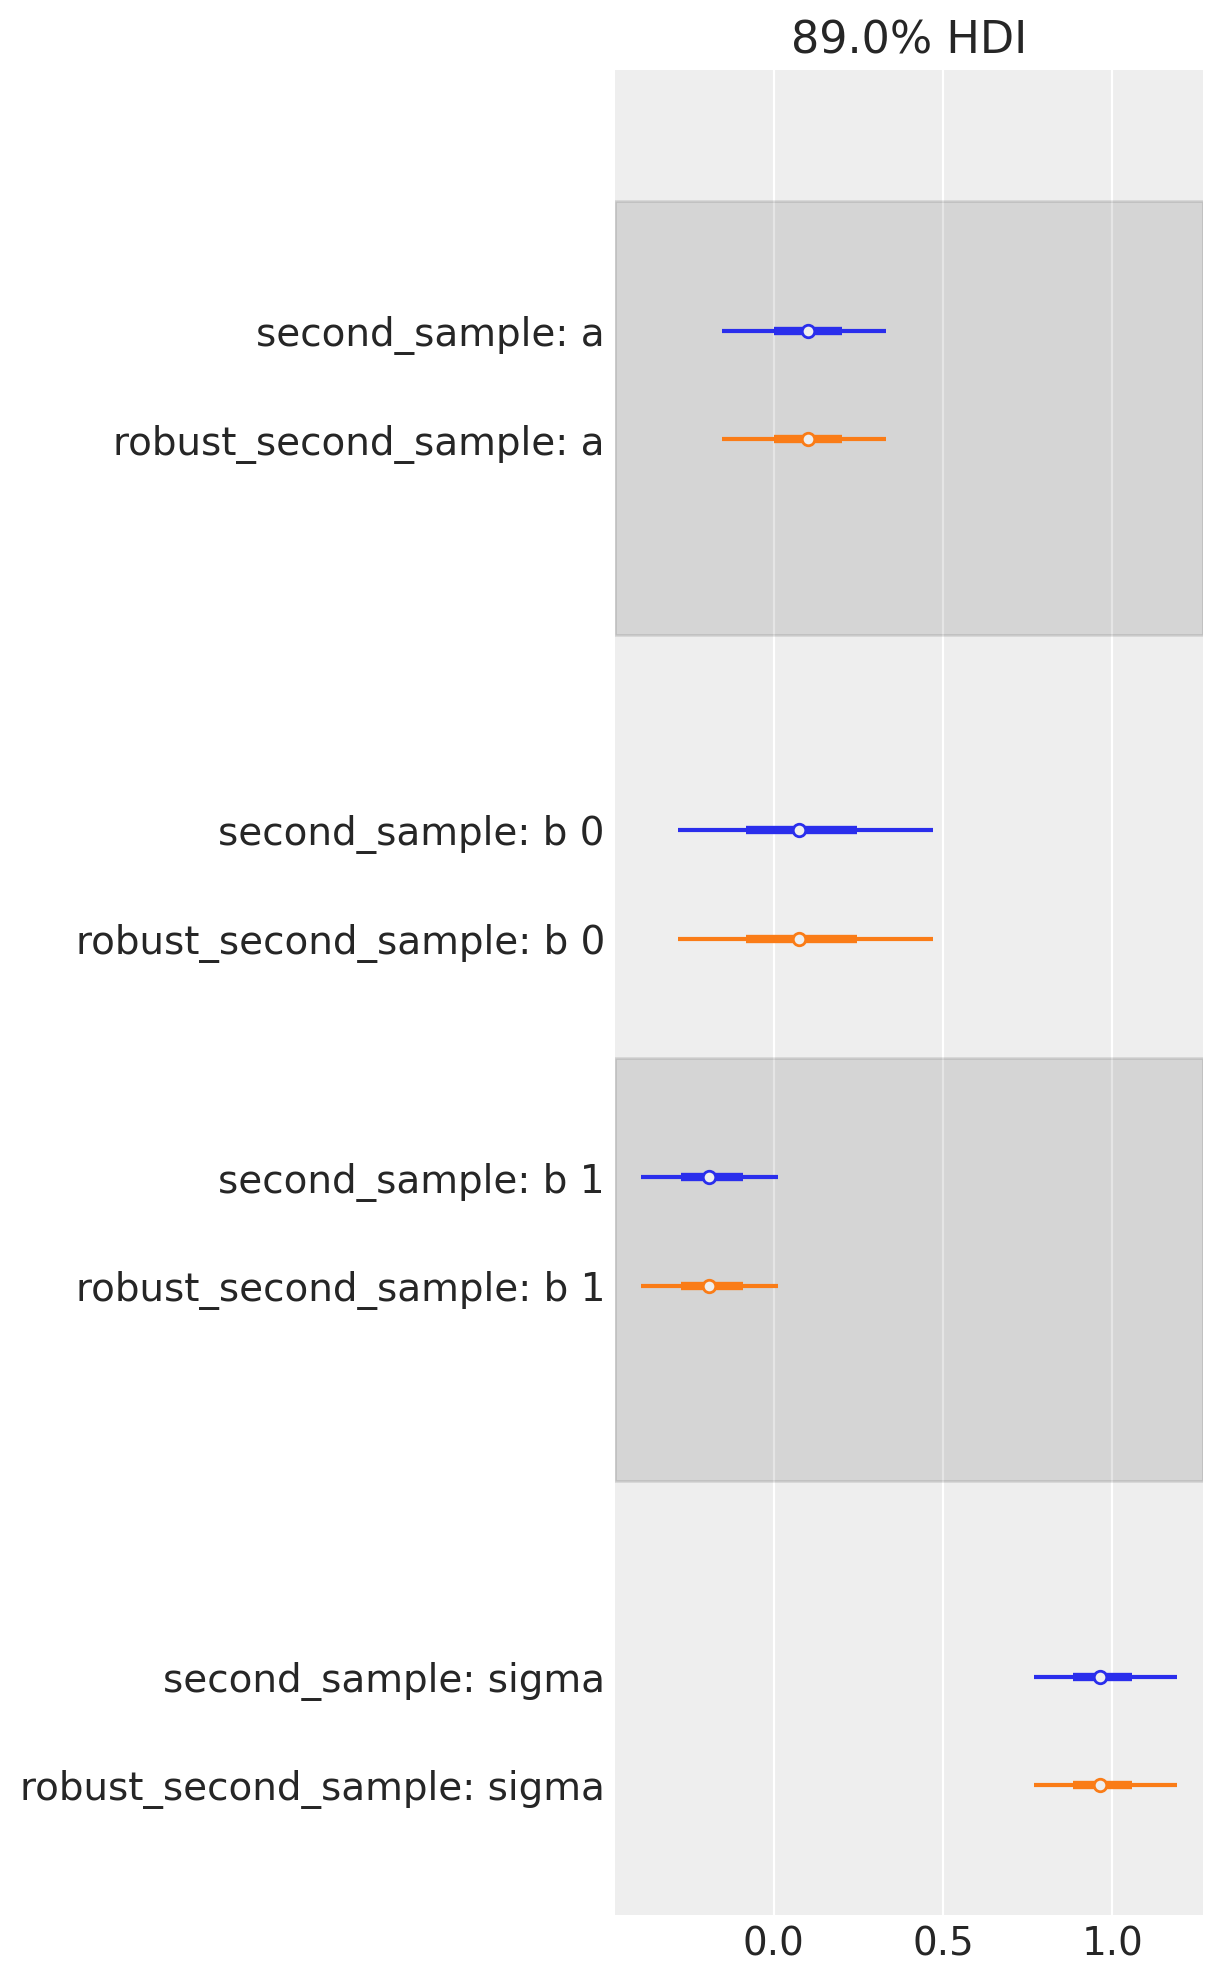

In [35]:
az.plot_forest(
    [second_sample, second_sample],
    model_names=["second_sample", "robust_second_sample"],
    combined=True,
    var_names=["a", "b", "sigma"],
);

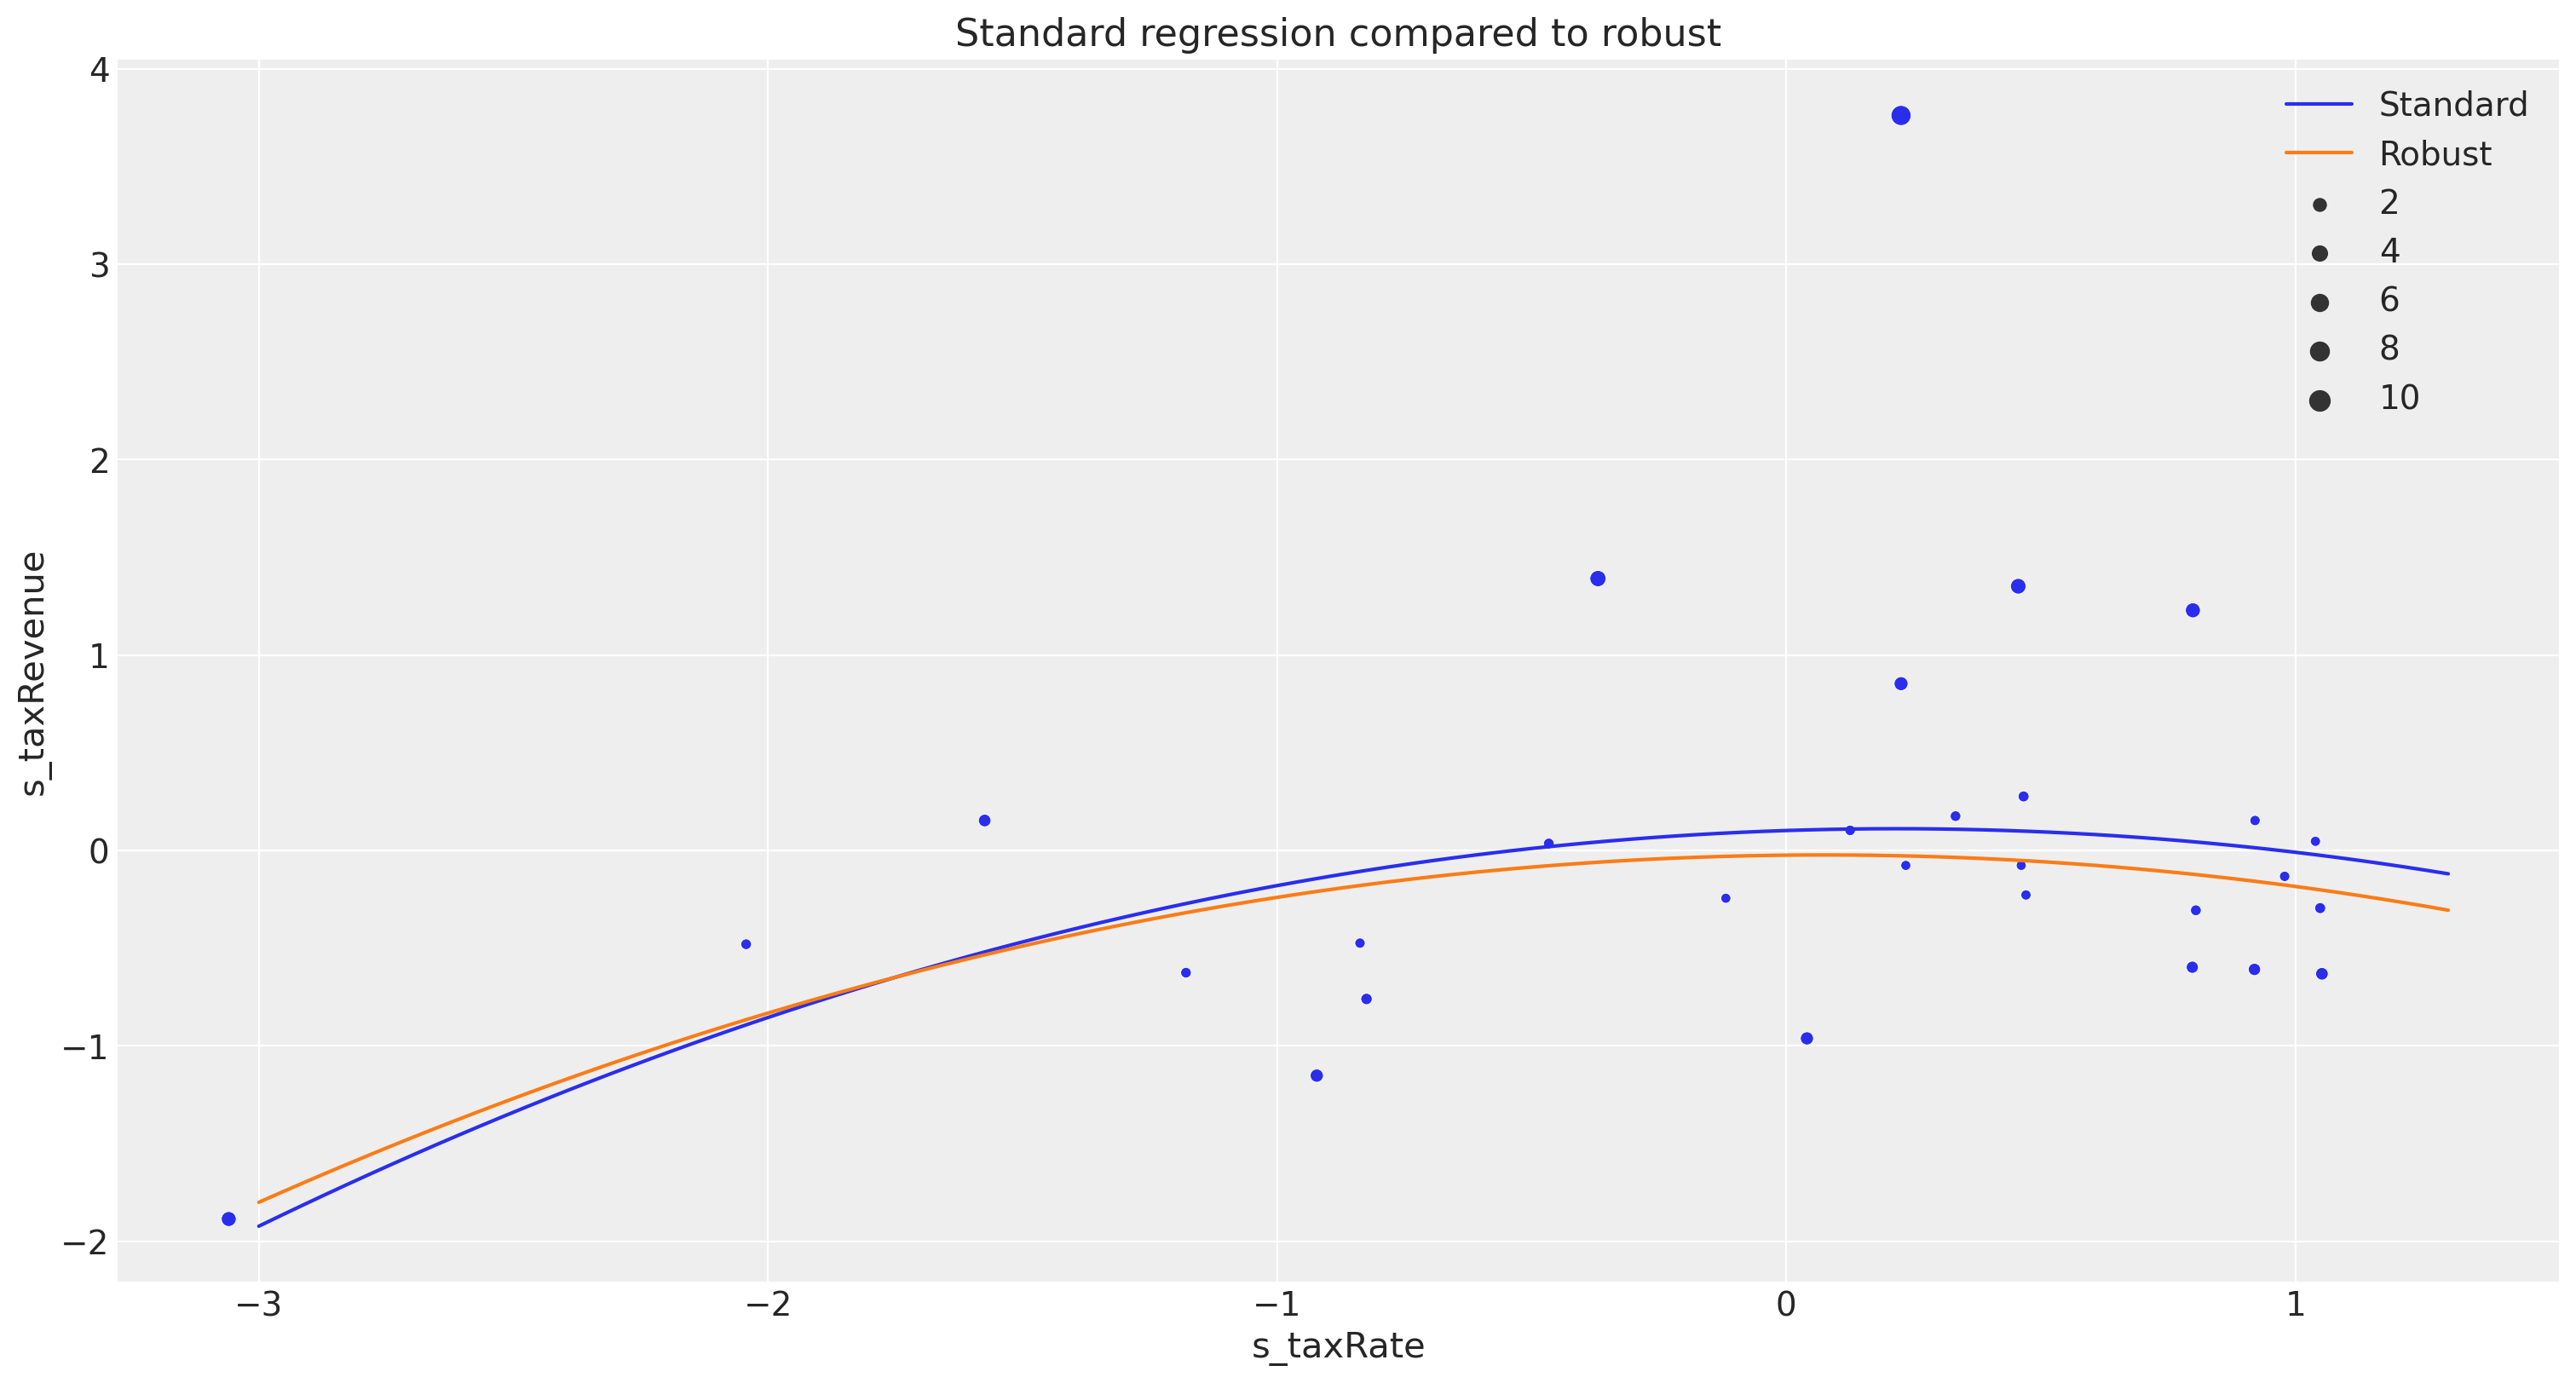

In [36]:
fig, axs = plt.subplots(figsize=(15, 8))

x = np.linspace(-3, 1.3, 100)
y1 = ppc["mu"]
y2 = robust_ppc["mu"]
plt.title("Standard regression compared to robust")
plt.plot(x, y1.mean(0), label="Standard")
plt.plot(x, y2.mean(0), label="Robust")
sns.scatterplot(x="s_taxRate", y="s_taxRevenue", data=Laffer, size=robust_first_waic.waic_i.values);

The effect of using robust regression is even smaller for the second order model, as the 2nd order parameter already copes with the outlier and wasn't as drastically impacted as the first model was anyway.

### 7H3.
Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by
the king with surveying the bird population. They have each found the following proportions of 5
important bird species:


| Island |Species A | Species B | Species C | Species D | Species E |
| --- | --- | --- |  --- | --- | --- |
|Island 1| 0.2 | 0.2 | 0.2 | 0.2 | 0.2 |
|Island 2| 0.8| 0.1| 0.05| 0.025| 0.025|
|Island 3 |0.05 |0.15 |0.7 |0.05 |0.05|


Notice that each row sums to 1, all the birds. This problem has two parts. It is not computationally
complicated. But it is conceptually tricky. First, compute the entropy of each island’s bird distribution.
Interpret these entropy values. Second, use each island’s bird distribution to predict the other two.
This means to compute the KL divergence of each island from the others, treating each island as if it
were a statistical model of the other islands. You should end up with 6 different KL divergence values.
Which island predicts the others best? Why?

#### Answer 


Island1 :=  H = log(5)

In [37]:
np.log2(5)

2.321928094887362

Island2 :=

In [38]:
-0.8 * np.log2(0.8) - 0.1 * np.log2(0.1) - 0.05 * np.log2(0.05) - 0.05 * np.log(0.025)

0.9902756628486911

In [39]:
# speeding things up a bit
p3 = np.array([0.05, 0.15, 0.7, 0.05, 0.05])
-np.inner(p3, np.log2(p3))

1.4190352743388661

In [40]:
p1 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
p2 = np.array([0.8, 0.1, 0.05, 0.025, 0.025])
dists = [p1, p2, p3]

These are the information entropies for the bird species given that you're in a specific Island, which is roughly how uncertain you are about what species of bird the next bird you encounter will be.

In [41]:
p1 / p2

array([0.25, 2.  , 4.  , 8.  , 8.  ])

To compute the KL divergence $D_{KL}(P||Q) = \sum P_i log(\frac{P_i}{Q_i})$

In [42]:
divergence_pairs = np.array([np.inner(p, np.log2(p / q)) for p in dists for q in dists]).reshape(
    3, 3
)

In [43]:
A = "abc"
B = "cde"

In [44]:
np.array([p + q for p in A for q in B]).reshape(3, 3)

array([['ac', 'ad', 'ae'],
       ['bc', 'bd', 'be'],
       ['cc', 'cd', 'ce']], dtype='<U2')

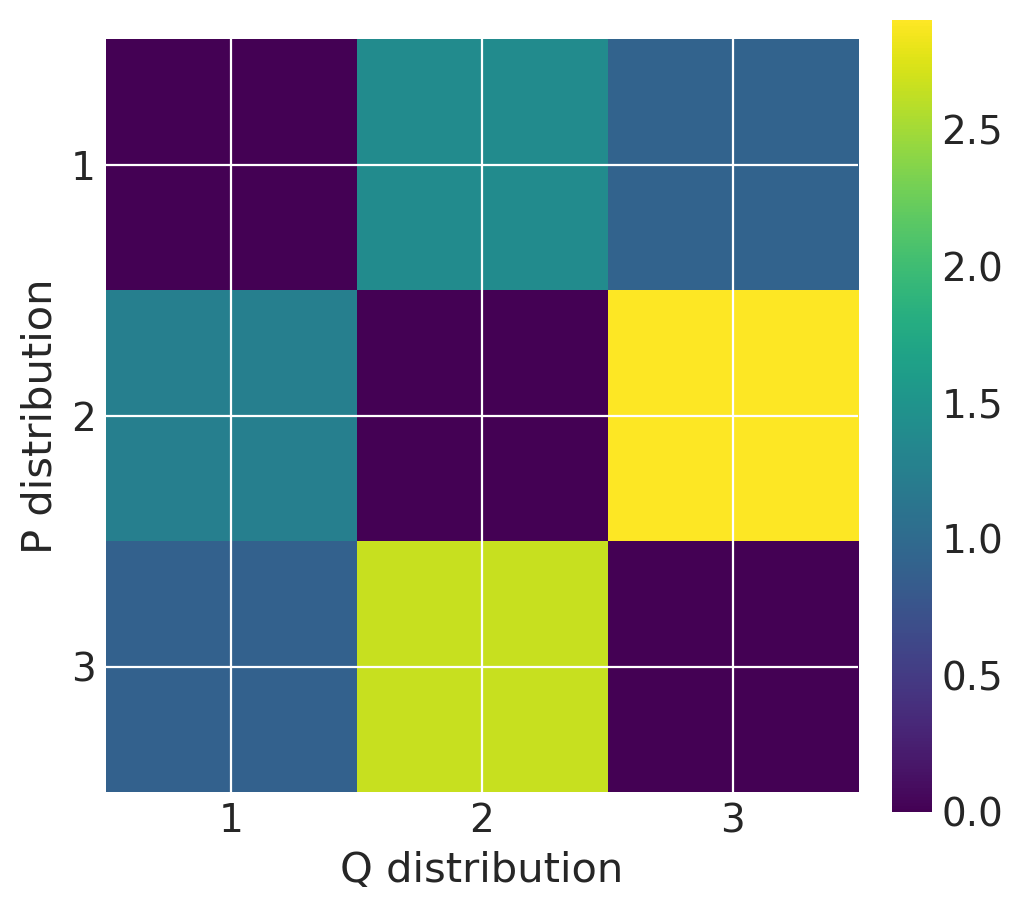

In [45]:
fig = plt.figure(figsize=(5, 5))
labels = [1, 2, 3]
ax = fig.add_subplot(111)  # define axis, so we can modify
im = ax.imshow(divergence_pairs)  # display the matrix
ax.set_xticks(np.arange(len(labels)))  # show them all!
ax.set_yticks(np.arange(len(labels)))  # show them all!
ax.set_xticklabels(labels)  # set to be the abbv (vs useless #)
ax.set_yticklabels(labels)
fig.colorbar(im, shrink=0.8)
plt.xlabel("Q distribution")
plt.ylabel("P distribution");

As can be seen from the heatmap of divergence pairs in the figure above, all distributions have zero divergence from themselves. These are the zeros on the diagonal. Distributions of Islands 1 and 3 model each other fairly well, as the probability masses assigned are fairly similar. Using Island 2's distribution to model Island 3 would be bad. This is because on Island 2 you would never expect to see species C, whilst on Island 3 species C is fairly common. Someone from Island 2 on Island 3 would be consistently surprised by the regular occurrence of species C that they were observing. In contrast to this someone from Island 3 on Island 2 would always be astonished by the regular occurrence of species A birds that they were observing.

Mean while all other directional pairs of distribution divergence is relatively low. All the bird pair frequencies are of comparable frequencies, at least in terms of their order of magnitude of occurrence, and you would never be obviously surprised by how often these different occurrences were taking place.

### 7H4.

Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models
m6.9 and m6.10 again (page 178). Compare these two models usingWAIC (or PSIS, they will produce
identical results). Which model is expected to make better predictions? Which model provides the
correct causal inference about the influence of age on happiness? Can you explain why the answers
to these two questions disagree?

In [46]:
# load the data up
Waffle = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")

The code below to generate the data is sourced from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb.

In [47]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [48]:
popn = sim_happiness()

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(
    int
)  # this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


In [49]:
popn["s_age"] = standardise(popn.age)
popn["s_happiness"] = standardise(popn.happiness)

In [50]:
popn.married + 0

0       0
1       0
2       0
3       0
4       0
       ..
1295    0
1296    0
1297    0
1298    0
1299    1
Name: married, Length: 1300, dtype: int64

In [51]:
# set up the two multiple regression models

# This model includes marital status
with pm.Model() as m6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    b = pm.Normal("b", 0, 2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", popn.s_age)
    cid = pm.intX(pm.Data("cid", popn.married + 0))
    mu = pm.Deterministic("mu", a[cid] + b * x)
    Happy = pm.Normal("Happy", mu, sd=sigma, observed=popn.s_happiness)
    m6_9Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

# This model ignores marital status
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 2)
    sigma = pm.Exponential("sigma", 1)
    x = pm.Data("x", popn.s_age)
    mu = pm.Deterministic("mu", a + b * x)
    Happy = pm.Normal("Happy", mu, sd=sigma, observed=popn.s_happiness)
    m6_10Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


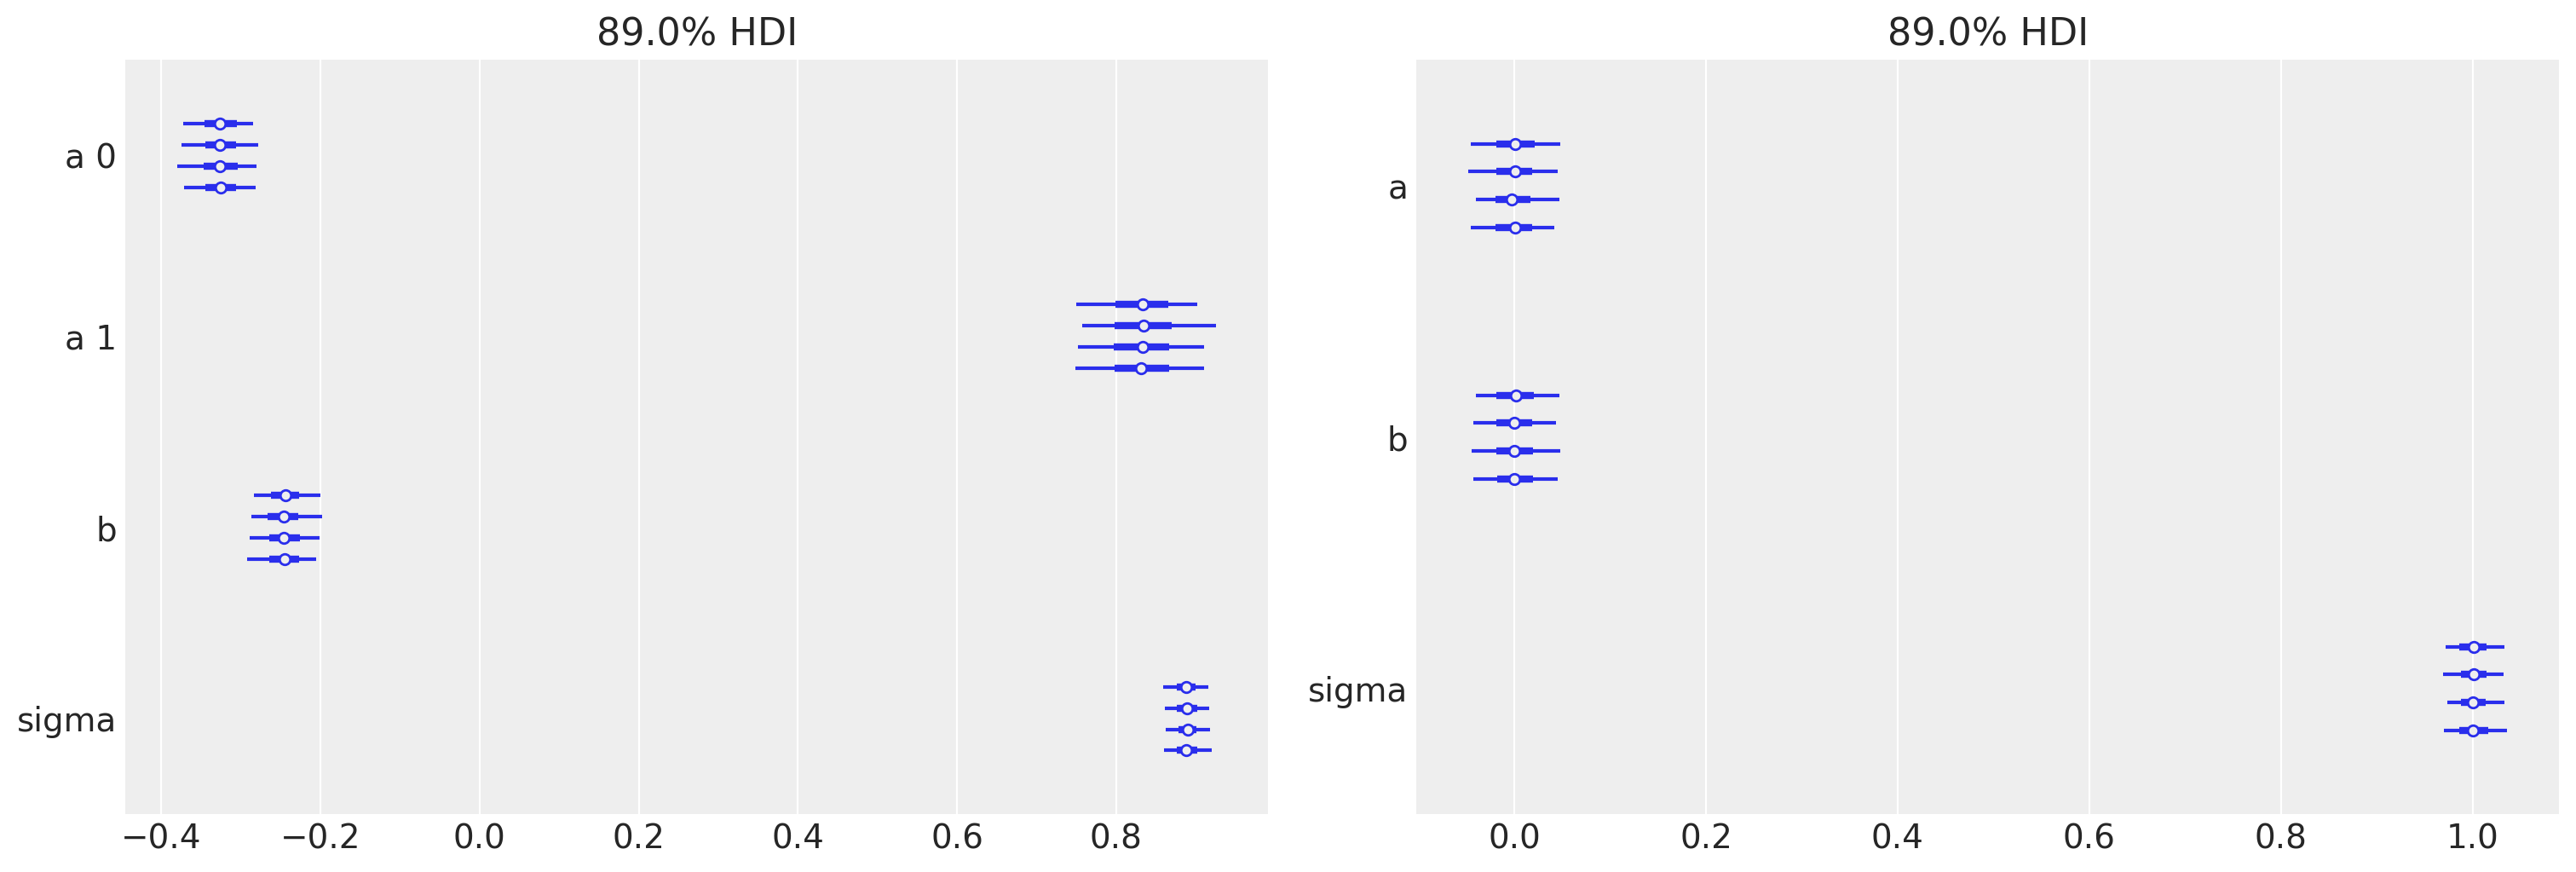

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("Standard Linear regression")
az.plot_forest(m6_9Sample, ax=axs[0], var_names=["a", "b", "sigma"])
axs[1].set_title("Robust Linear regression")
az.plot_forest(m6_10Sample, ax=axs[1], var_names=["a", "b", "sigma"]);

In [53]:
with m6_9:
    pm.set_data({"x": np.linspace(-1.7, 1.7, 50), "cid": np.zeros(50, dtype=int)})
    single_ppc = pm.sample_posterior_predictive(m6_9Sample, 1000, var_names=["mu"])
    pm.set_data({"x": np.linspace(-1.7, 1.7, 50), "cid": np.zeros(50, dtype=int) + 1})
    married_ppc = pm.sample_posterior_predictive(m6_9Sample, 1000, var_names=["mu"])

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


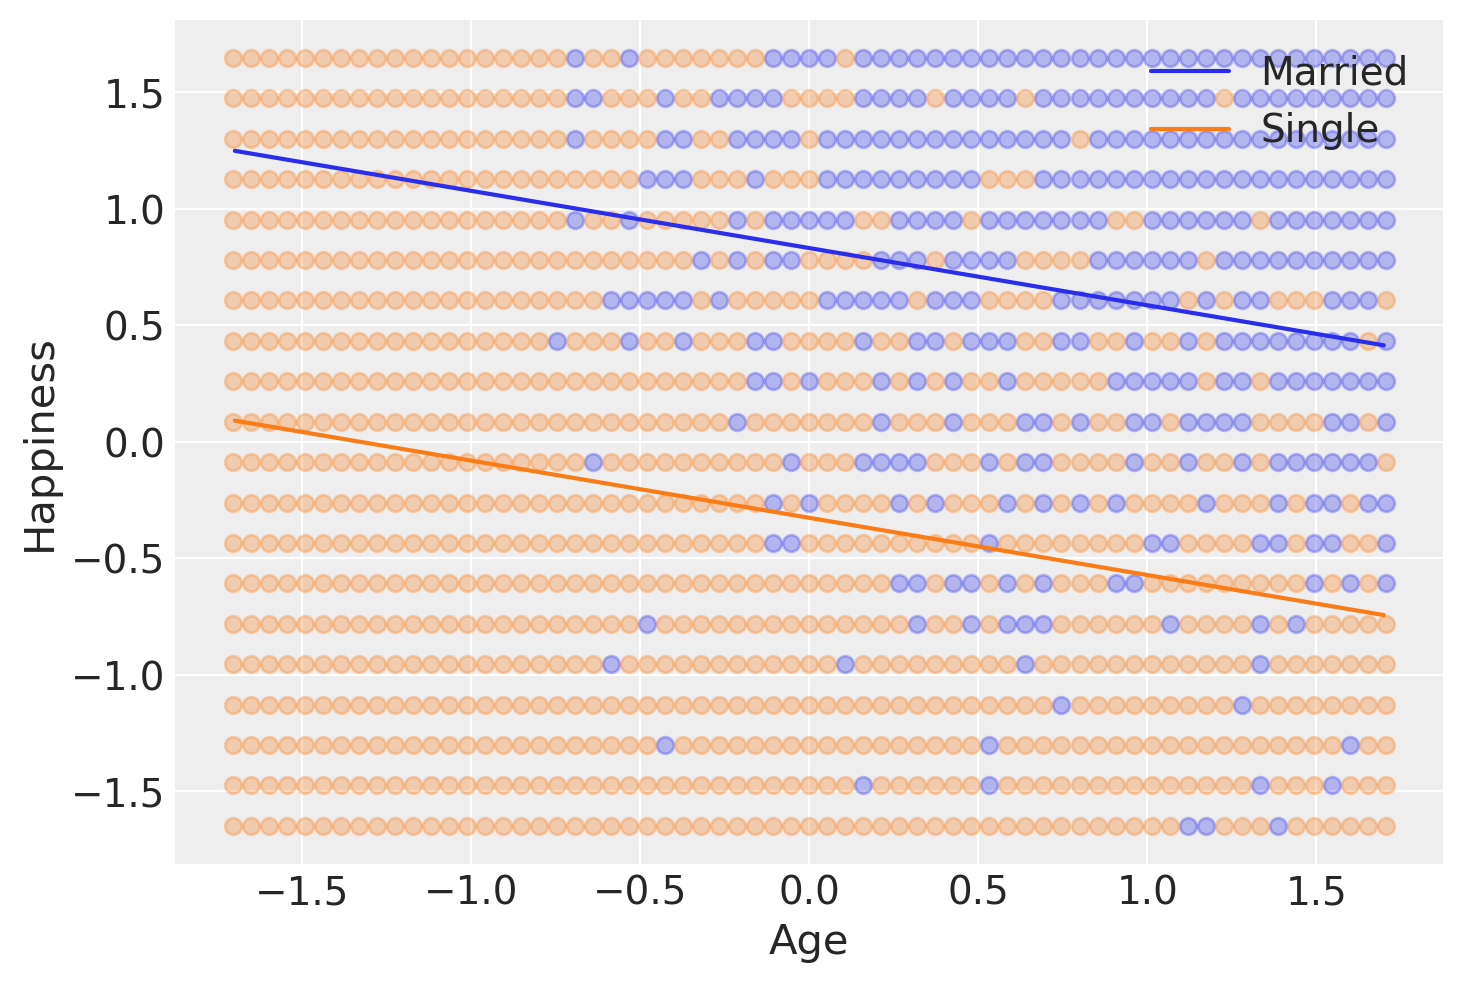

In [54]:
x1 = np.linspace(-1.7, 1.7, 50)

plt.plot(x1, married_ppc["mu"].mean(0), label="Married")
plt.scatter(popn[popn.married == True].s_age, popn[popn.married == True].s_happiness, alpha=0.3)
plt.scatter(
    popn[popn.married == False].s_age,
    popn[popn.married == False].s_happiness,
    alpha=0.3,
)
plt.plot(x1, single_ppc["mu"].mean(0), label="Single")
plt.xlabel("Age")
plt.ylabel("Happiness")
plt.legend();

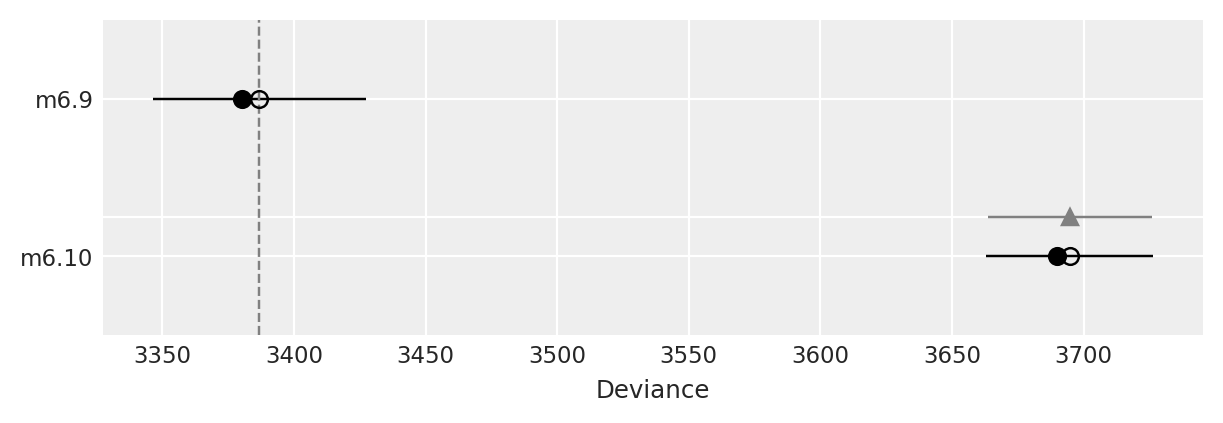

In [55]:
compare_df = az.compare({"m6.9": m6_9Sample, "m6.10": m6_10Sample}, scale="deviance", ic="waic")
az.plot_compare(compare_df);

In [56]:
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.9,0,3386.87,3.36719,0,1,40.3715,0,False,deviance
m6.10,1,3694.79,2.45514,307.917,1.639e-49,31.7241,31.2321,False,deviance


The waic is much smaller for model 3.9, the false model. This is a false causal model, as conditioning on marriage is an example of collider bias in the model. However it has a lower deviance, and greater predictive power than the true causal model, as knowing whether you're married offers insight about whether or not you're happy. It offers insight be because it's caused by happiness rather than causing it in the model laid out above.

### 7H5.
Revisit the urban fox data, data(foxes), from the previous chapter’s practice problems. Use
WAIC or PSIS based model comparison on five different models, each using weight as the outcome,
and containing these sets of predictor variables:

(1) avgfood + groupsize + area

(2) avgfood + groupsize

(3) groupsize + area

(4) avgfood

(5) area

Can you explain the relative differences in WAIC scores, using the fox DAG from the previous chapter? Be sure to pay attention to the standard error of the score differences (dSE).

In [57]:
Foxy = pd.read_csv("./data/foxes.csv", delimiter=";")

In [58]:
# standardise all variables
for column in Foxy.columns.values:
    Foxy["s_" + column] = standardise(Foxy[column])

In [59]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1, shape=3)
    sigma = pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 6:9].values, beta)
    Weight = pm.Normal("Weight", mu, sd=sigma, observed=Foxy.weight)
    m1Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as model2:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 6:8].values, beta)
    Weight = pm.Normal("Weight", mu, sd=sigma, observed=Foxy.weight)
    m2Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as model3:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1, shape=2)
    sigma = pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 7:9].values, beta)
    Weight = pm.Normal("Weight", mu, sd=sigma, observed=Foxy.weight)
    m3Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as model4:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 6].values, beta)
    Weight = pm.Normal("Weight", mu, sd=sigma, observed=Foxy.weight)
    m4Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

with pm.Model() as model5:
    alpha = pm.Normal("alpha", 0, 1)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = alpha + pm.math.dot(Foxy.iloc[:, 8].values, beta)
    Weight = pm.Normal("Weight", mu, sd=sigma, observed=Foxy.weight)
    m5Sample = pm.sample(draws=1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8831621656530025, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8792112429586016, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8802245469006368, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [60]:
# compare these models with
compare_df = az.compare(
    {
        "model1": m1Sample,
        "model2": m2Sample,
        "model3": m3Sample,
        "model4": m4Sample,
        "model5": m5Sample,
    },
    ic="waic",
    scale="deviance",
)
compare_df

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,362.844,4.99431,0,0.262072,16.1854,0,True,deviance
model2,1,363.155,3.8204,0.311278,0.351693,15.8371,3.51822,True,deviance
model3,2,363.192,3.68568,0.348537,0.325292,15.896,3.47233,True,deviance
model4,3,373.262,2.52258,10.4181,0.0293041,13.6445,7.59643,False,deviance
model5,4,373.449,2.71324,10.6051,0.0316392,13.6445,7.64336,False,deviance


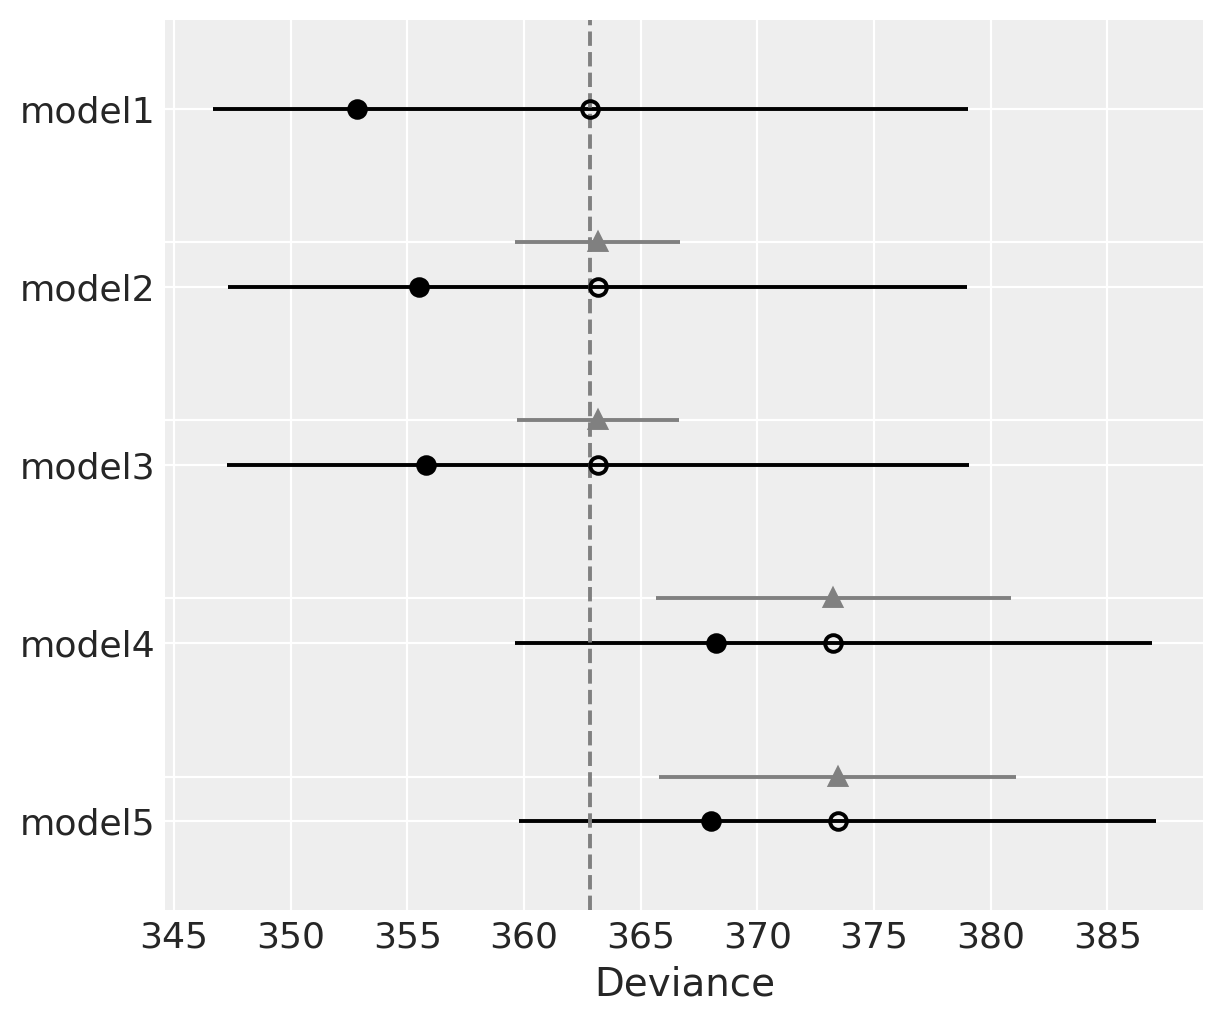

In [61]:
az.plot_compare(compare_df);

It can be seen that the two simplest models have the largest deviances, showing that they're missing a lot of out of sample predictive power. Using avgfood or area on their own will be masked by the group size effects, hence such models are weak for predicting weight. See the DAG below.

All of the other models however contain groupsize, and so the predictive power of a variable that has a direct impact of weight is very helpful for improving the model's performance. It's especially good as this variable unveils the masking effect that's there. The first three models use groupsize alongside either area, avgfood or both. As avgfood is a mediator of area, it doesn't matter which of the two (or even if both) are used, as they contain more or less the same set of information (with varying amounts of noise).

So to summarise, models that use just area (and its mediator) perform badly at prediction the outcome due to the mixed counteracting causal role that it has. If you unmask, you'll get a model with good predictive power and low deviance.

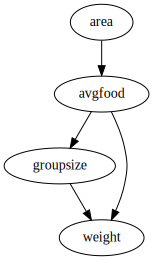

In [62]:
Foxy = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)


# draw return a graphviz `dot` object, which jupyter can render
Foxy.draw()

In [63]:
%watermark -n -u -v -iv -w

Last updated: Sat Dec 26 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

arviz     : 0.9.0
pymc3     : 3.9.3
seaborn   : 0.11.0
matplotlib: 3.3.2
pandas    : 1.1.3
numpy     : 1.19.1
scipy     : 1.5.2

Watermark: 2.1.0

